Presentado por Juan Carranza, Federico Medina y Alejandro Mesa

Introducción

Para este trabajo final se utilizó la serie de desempleo de los Estados Unidos de América debido a que  se consideró que era un enfoque importante utilizar  una  serie con todas las características vistas en el curso como ciclos, tendencias e incluso estacionalidades. Para ello vamos a realizar un análisis completo de la serie sin tener en cuenta el choque de covid-19. Este documento tendrá una estructura definida: En la primera sección un análisis de tipo característico de la serie donde se analizarán los diferentes aspectos de la misma como la correlación con sus  rezagos, monthplots y análisis de funciones de autocorrelación de la serie diferenciada y original.

En la segunda sección se encontraran diferentes modelos de tipo descriptivo que utilizaremos para analizar nuestra serie de tiempo como modelos  suavizamiento exponencial y modelación de ciclos para poder realizar de manera óptima nuestro modelamiento por medio de técnicas que se dieron en el curso como lo son árboles de decisión bosques aleatorios redes neuronales y el ajuste de un modelo arima.

En la tercera sección nos dedicaremos a presentar los modelos, sus estadísticos de interés como r cuadrado, score,  funciones de autocorrelación de los errores y sus respectivas comparaciones para al final decidir cuál de los modelos es el más adecuado para ajustar nuestra serie de tiempo. 


In [281]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import random 
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import seaborn as sns
import tensorflow.keras as keras

from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
rcParams['figure.figsize'] = 15, 10
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.tsa.seasonal import seasonal_decompose

InteractiveShell.ast_node_interactivity = "all"


import tensorflow.keras as keras

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import jarque_bera
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Importación de datos. 


In [282]:
serie = pd.read_excel(r"E:\PERSONAL\UN\Maestría Estadística\1. Primer Semestre\3. Teoría de Series de Tiempo Univariadas\Trabajo Final\UNRATE.xls")
serie.tail()

,observation_date,UNRATE
859,2019-08-01,3.7
860,2019-09-01,3.5
861,2019-10-01,3.6
862,2019-11-01,3.6
863,2019-12-01,3.6


In [283]:
serie['observation_date'] = pd.to_datetime(serie['observation_date'], yearfirst= True)
serie.head()

,observation_date,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [284]:
Fecha = serie.loc[:,'observation_date']
serie.index = pd.DatetimeIndex(list(serie['observation_date']))
serie = serie.drop(['observation_date'], axis = 1)
serie.head()

,UNRATE
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


Text(0.5, 1.0, 'Desempleo EE.UU.')

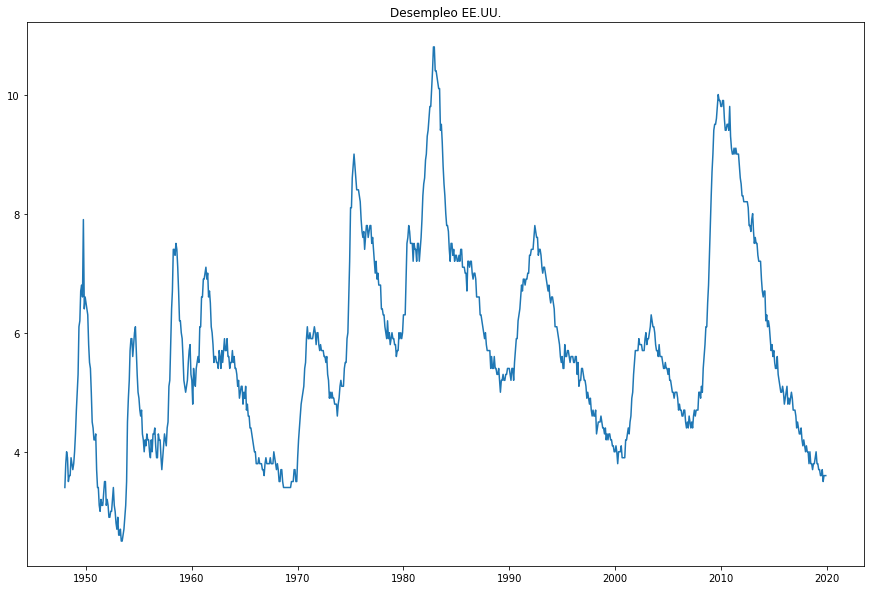

864

In [285]:
plt.plot(serie)
plt.title('Desempleo EE.UU.')
plt.show()
serie.size

Es posible observar que la serie no parece estacionaria, debido a que sí bien parece que tiene una oscilación alrededor de una media, tiene notables ciclos que más adelante deberán ser modelados

# Análisis descriptivo de las series

## Gráficas de retardos

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 't vs t-1')

Text(0.5, 1.0, 't vs t-2')

Text(0.5, 1.0, 't vs t-3')

Text(0.5, 1.0, 't vs t-4')

Text(0.5, 1.0, 't vs t-5')

Text(0.5, 1.0, 't vs t-6')

Text(0.5, 1.0, 't vs t-7')

Text(0.5, 1.0, 't vs t-8')

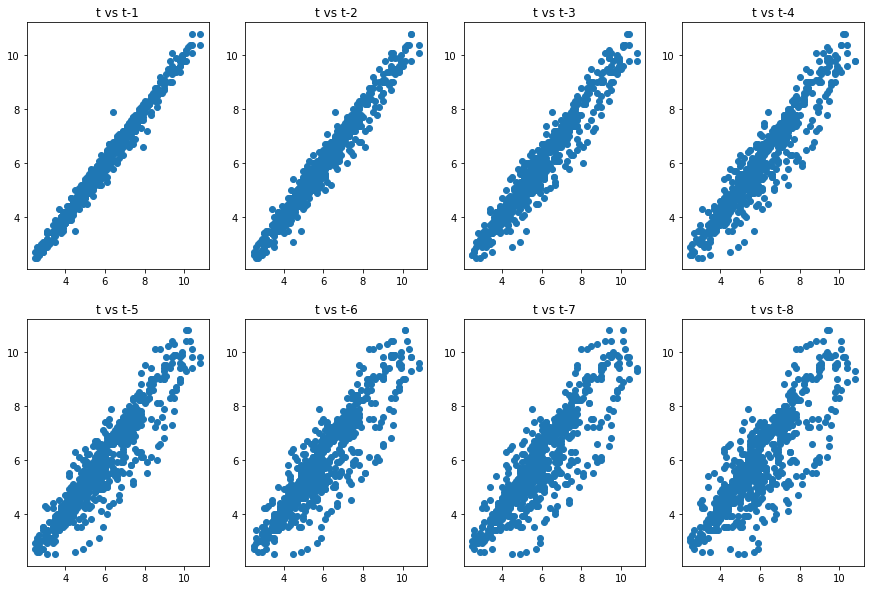

In [286]:
from pandas.plotting import scatter_matrix
values = pd.DataFrame(serie.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t vs t-' + str(i))
	plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

Se puede ver que la variable tiene importantes correlaciones positivas hasta el rezago 8; esto nos da una idea de cómo podemos crear nuestras covariables a la hora de fitear nuestros modelos

## Monthplot

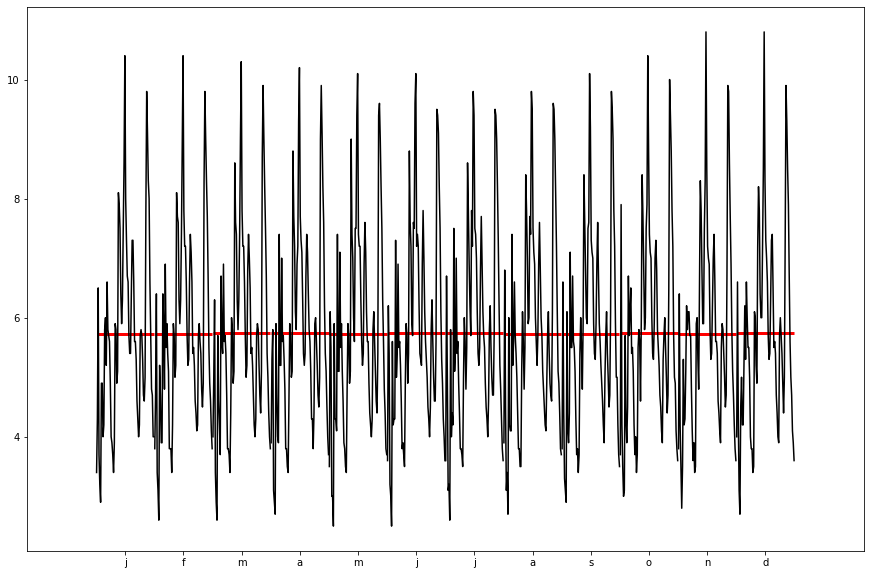

In [287]:
_=sm.graphics.tsa.month_plot(serie)

## Heatmap para ciclos

In [288]:
fig = go.Figure(data = go.Heatmap(y = serie.index.month, 
                                  x = serie.index.year,
                                  z = (serie.loc[:,"UNRATE"]),
                                  colorscale = 'Viridis' ))
fig

La serie recuperada de la FRED de St. Louis tiene la particularidad de ser una serie sin estacionalidades, explicando el por qué no encontramos un patrón mensual muy marcado cómo es habitual de encontrar en series de tipo económicas. Particularmente, vemos tanto en el monthplot como en el heatmap para chequear las estacionalidades que no hay problemas de este tipo, sin embargo, sí podemos notar algunos pequeños ciclos a través de los años en zonas muy oscuras o muy claras del heatmap.

## Análisis de rezagos

### MA


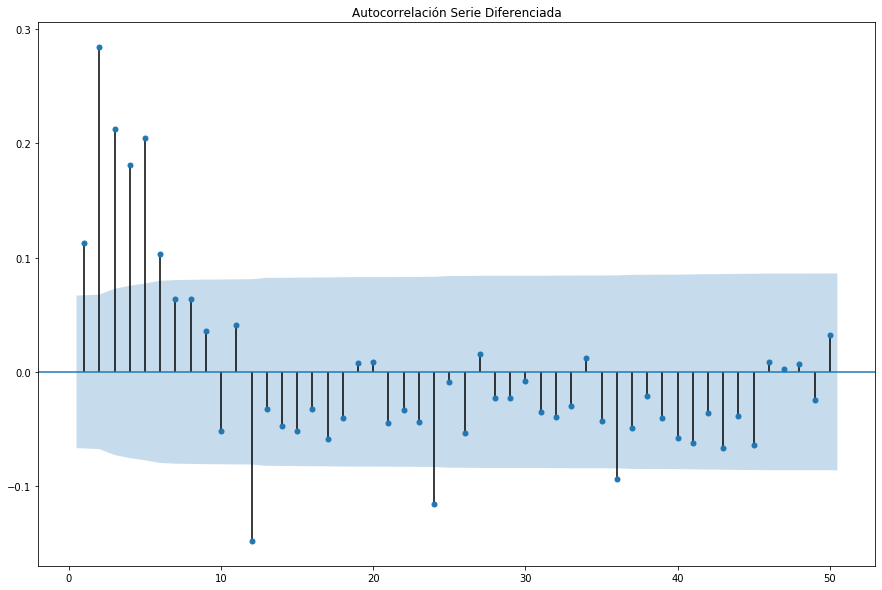

In [289]:
_=plot_acf(serie.diff(1)[1:], lags = 50, title = 'Autocorrelación Serie Diferenciada', zero = False)

### AR

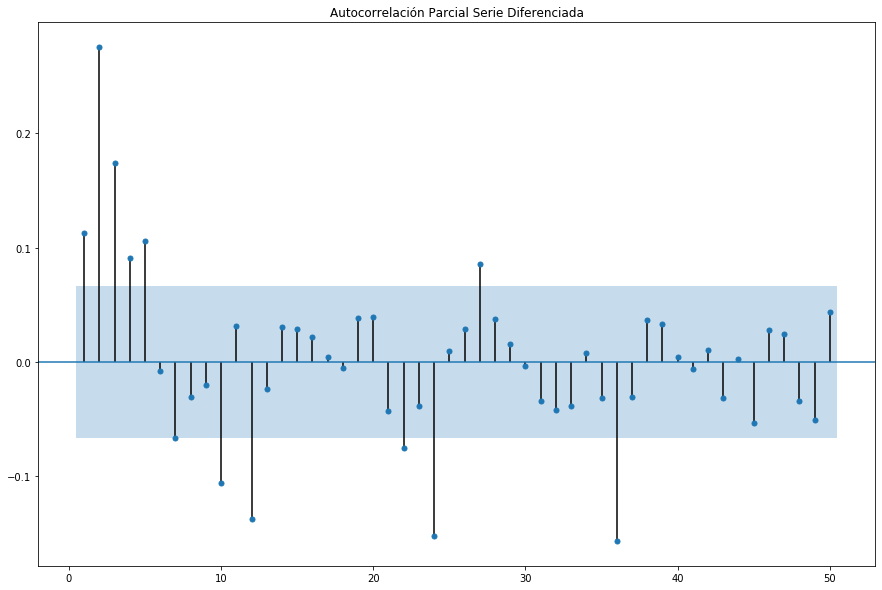

In [290]:
_=plot_pacf(serie.diff(1)[1:], lags = 50, title = 'Autocorrelación Parcial Serie Diferenciada', zero = False)

Como parte de nuestro chequeo para los posteriores modelos que se tratarán de ajustar, en los efectos de media móvil por medio de la función de autocorrelación, encontramos rezagos estadísticamente significativos en las primeras 5 observaciones; mientras que por los efectos autoregresivos, adicionalmente tenemos un efecto estacional cada 12 períodos. Es importante notar esto ya que será útil más adelante sí se desea realizar el ajuste de un modelo ARIMA

# Modelación Descriptiva y Suavizamiento

## Partición Train-Test

In [291]:
serie_diff = serie.diff(1)
X_diff = pd.DataFrame()
for i in range(12,0,-1):
    X_diff[['t-'+str(i)]] = pd.DataFrame(serie_diff).shift(i)

X_diff = X_diff[13:]

serie = serie
X = pd.DataFrame()
for i in range(12,0,-1):
    X[['t-'+str(i)]] = pd.DataFrame(serie).shift(i)

X = X[12:]

print(X)

            t-12  t-11  t-10  t-9  t-8  t-7  t-6  t-5  t-4  t-3  t-2  t-1
1949-01-01   3.4   3.8   4.0  3.9  3.5  3.6  3.6  3.9  3.8  3.7  3.8  4.0
1949-02-01   3.8   4.0   3.9  3.5  3.6  3.6  3.9  3.8  3.7  3.8  4.0  4.3
1949-03-01   4.0   3.9   3.5  3.6  3.6  3.9  3.8  3.7  3.8  4.0  4.3  4.7
1949-04-01   3.9   3.5   3.6  3.6  3.9  3.8  3.7  3.8  4.0  4.3  4.7  5.0
1949-05-01   3.5   3.6   3.6  3.9  3.8  3.7  3.8  4.0  4.3  4.7  5.0  5.3
...          ...   ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2019-08-01   3.8   3.7   3.8  3.8  3.9  4.0  3.8  3.8  3.7  3.7  3.6  3.6
2019-09-01   3.7   3.8   3.8  3.9  4.0  3.8  3.8  3.7  3.7  3.6  3.6  3.7
2019-10-01   3.8   3.8   3.9  4.0  3.8  3.8  3.7  3.7  3.6  3.6  3.7  3.5
2019-11-01   3.8   3.9   4.0  3.8  3.8  3.7  3.7  3.6  3.6  3.7  3.5  3.6
2019-12-01   3.9   4.0   3.8  3.8  3.7  3.7  3.6  3.6  3.7  3.5  3.6  3.6

[852 rows x 12 columns]


In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, serie.values[12:], test_size = 0.2, shuffle = False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(681, 12) (171, 12) (681, 1) (171, 1)


Utilizamos un tamaño de entrenamiento de 80% y de test de 20%, con covariables referidas a 12 períodos atrás, con el fin de tratar de capturar el efecto estacional identificado en la función de autocorrelación parcial. Además, los datos son recopilados de manera mensual, por lo que doce rezados son considerados suficientes como covariables

## Suavizado Exponencial

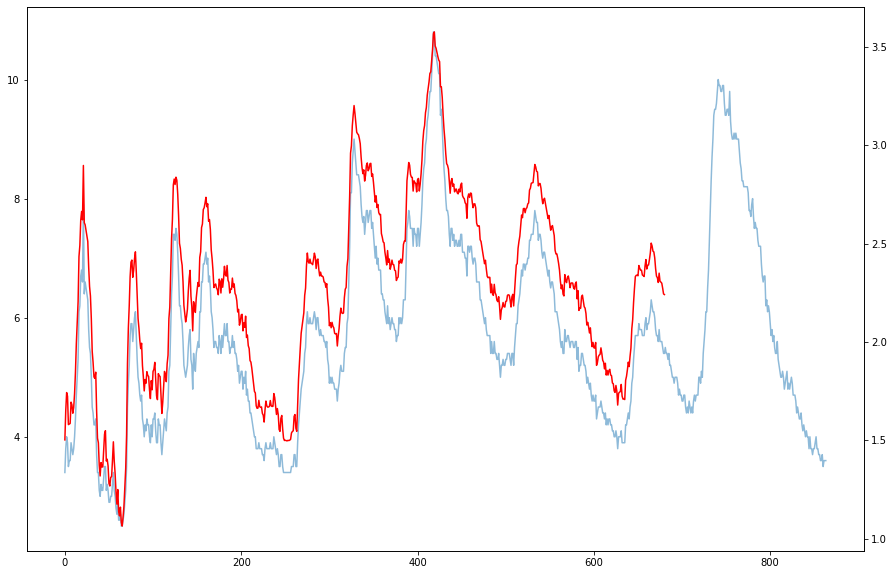

In [293]:
fit_exp = ExponentialSmoothing(serie.values[:681], seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()

fig, ax = plt.subplots(figsize = (15,10))
ax2 = ax.twinx()

ax.plot(serie.values, alpha = 0.5)
ax2.plot(fit_exp.level, color = 'red')

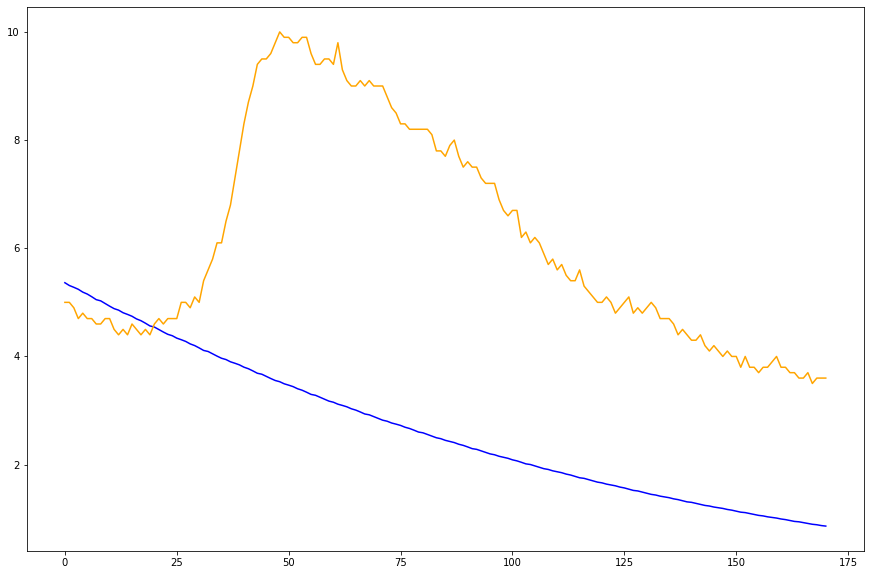

In [294]:
fcast1 = fit_exp.forecast(171)
plt.plot(fcast1, color='blue')
plt.plot(y_test, color='orange')

A la hora de hacer un suavizado exponencial a la serie para poder realizar pronóstico de la misma, nos encontramos con que no es capaz de capturar la varianza en el 20% de los datos de test restante, por lo que sólo toma parte de la tendencia que venía presentándose períodos atrás y la tendencia después del período 60, sin embargo, no puede ajustar lo suficientemente bien esta serie. 

## Transformación Box-Cox

In [295]:
serie_boxcox, lambda_serie, int_confianza = sp.stats.boxcox(serie.loc[:,'UNRATE'], alpha=0.05)

0.07319994088088237


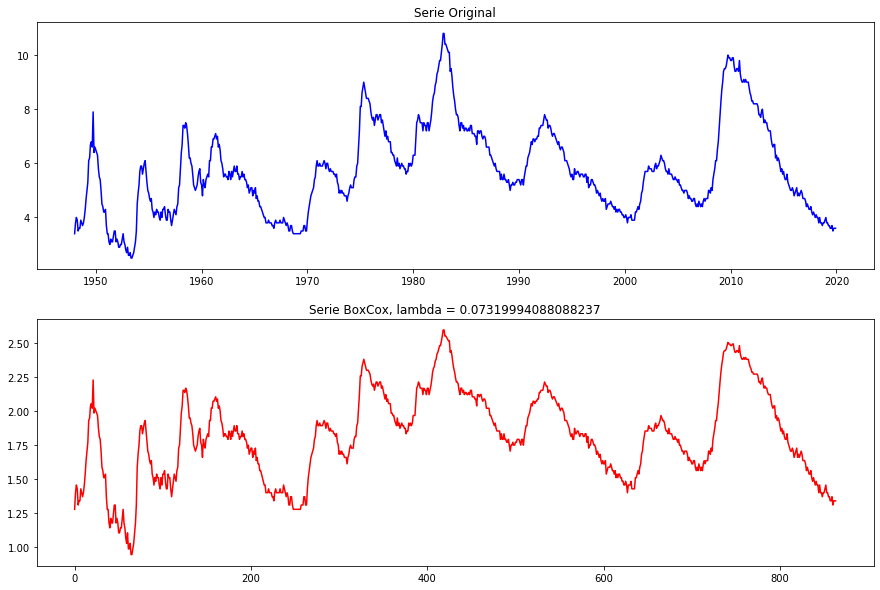

In [296]:
fig, axes = plt.subplots(2,1)
axes[0].plot(serie, color = 'blue')
axes[0].title.set_text('Serie Original')
axes[1].plot(serie_boxcox, color = "red")
axes[1].title.set_text('Serie BoxCox, lambda = {}'.format(lambda_serie))
print(lambda_serie)

Gráficamente es fácil corroborar que la transformación Box-Cox no hace un cambio significativo a la serie, por lo que a la hora de estabilizar la varianza marginal y encontrar "patrones" más claramente, no cumple su papel, por lo que en este trabajo no se utilizará la serie transformada por Box-Cox. 

## Descomposición previa

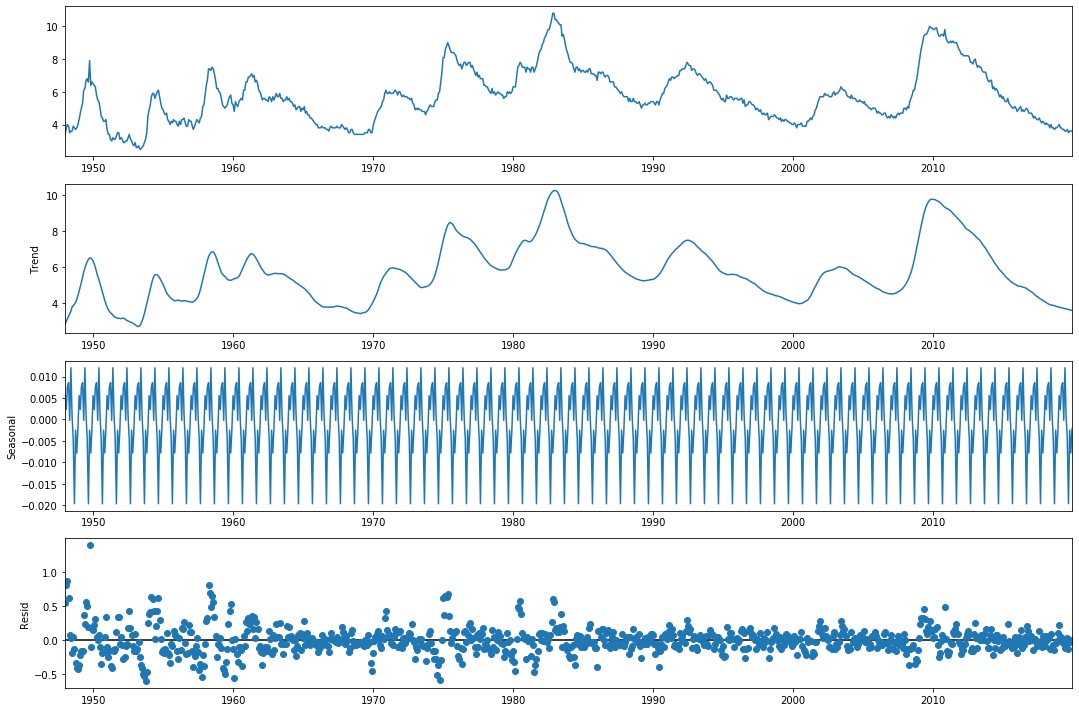

In [297]:
result = seasonal_decompose(serie, model='additive',extrapolate_trend=6)

_=result.plot()

En este gráfico que nos permite ver de manera clara una descomposición estacional y tendencia de la serie, es posible notar que hay ciclos que es necesario modelar, además de un efecto estacional persistente pero pequeño teniendo en cuenta que la serie se encuentra en órdenes de valores entre 4 y 10, y la estacionalidad calculada está entre -0.02 y 0.01. Para corregir esto, haremos uso de la técnica de senos y cosenos para poder retirar los ciclos a las series.

## Modelación del ciclo

### Serie Original

3
0.003472222222222222


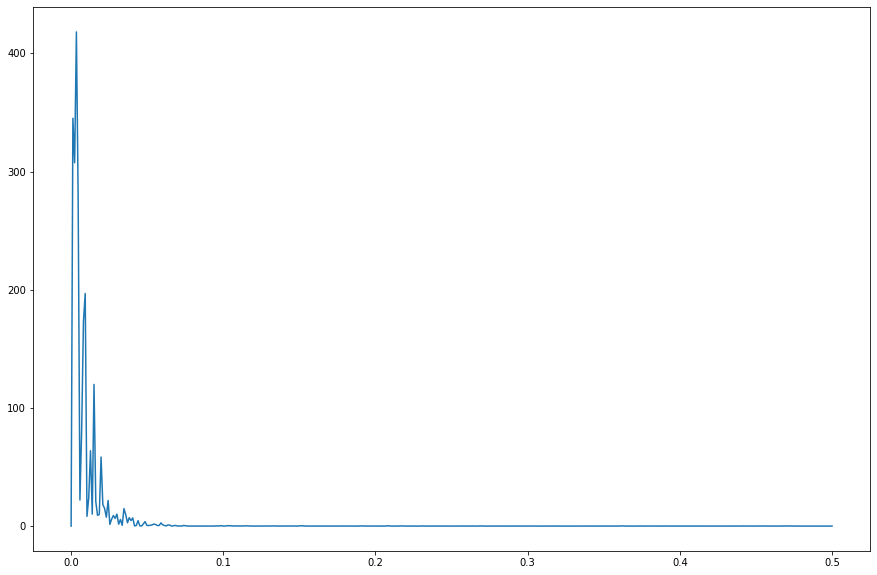

In [298]:
f, Pxx_den=sp.signal.periodogram(serie['UNRATE'])
plt.plot(f, Pxx_den)
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

In [299]:
periodos = pd.DataFrame({'f': f, 'valor': Pxx_den}).sort_values(by = 'valor', ascending=False).head(4).loc[:,'f']
periodos

3    0.003472
1    0.001157
2    0.002315
4    0.004630
Name: f, dtype: float64

In [300]:
cos1, cos2, cos3, cos4 = [np.cos(2*np.pi*np.arange(1,len(serie['UNRATE'])+1)/(1/periodo)) for periodo in periodos]
sen1, sen2, sen3, sen4 = [np.sin(2*np.pi*np.arange(1,len(serie['UNRATE'])+1)/(1/periodo)) for periodo in periodos]
ciclo_modelado=np.column_stack((cos1, cos2, cos3, cos4, sen1, sen2, sen3, sen4))
linmodel_ciclo = sm.OLS(serie['UNRATE'], ciclo_modelado)
results_ciclo_1 = linmodel_ciclo.fit()
print(results_ciclo_1.summary())

                                 OLS Regression Results                                
Dep. Variable:                 UNRATE   R-squared (uncentered):                   0.044
Model:                            OLS   Adj. R-squared (uncentered):              0.035
Method:                 Least Squares   F-statistic:                              4.906
Date:                Wed, 28 Jul 2021   Prob (F-statistic):                    6.07e-06
Time:                        20:41:29   Log-Likelihood:                         -2749.7
No. Observations:                 864   AIC:                                      5515.
Df Residuals:                     856   BIC:                                      5553.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

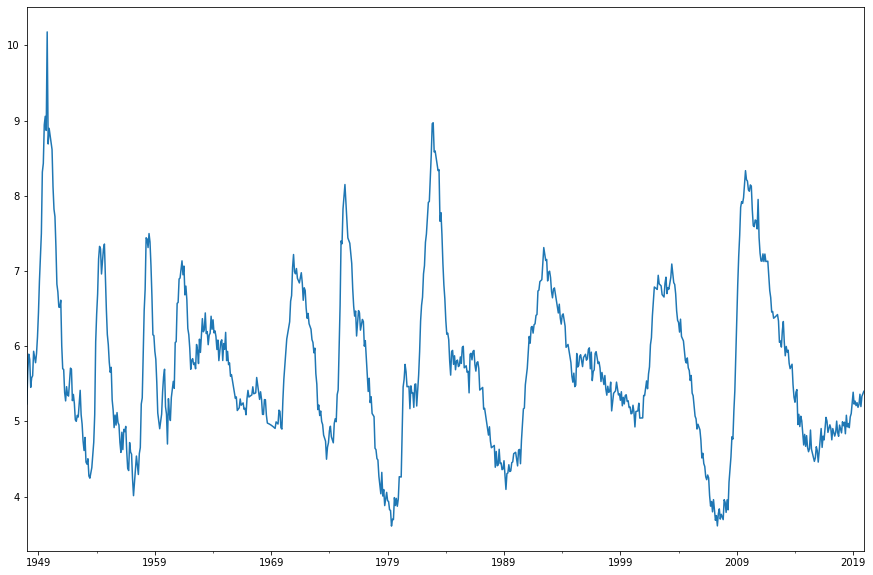

In [301]:
serie_ciclos_1 = serie['UNRATE'] - results_ciclo_1.fittedvalues
serie_ciclos_1.plot()

8
0.009259259259259259


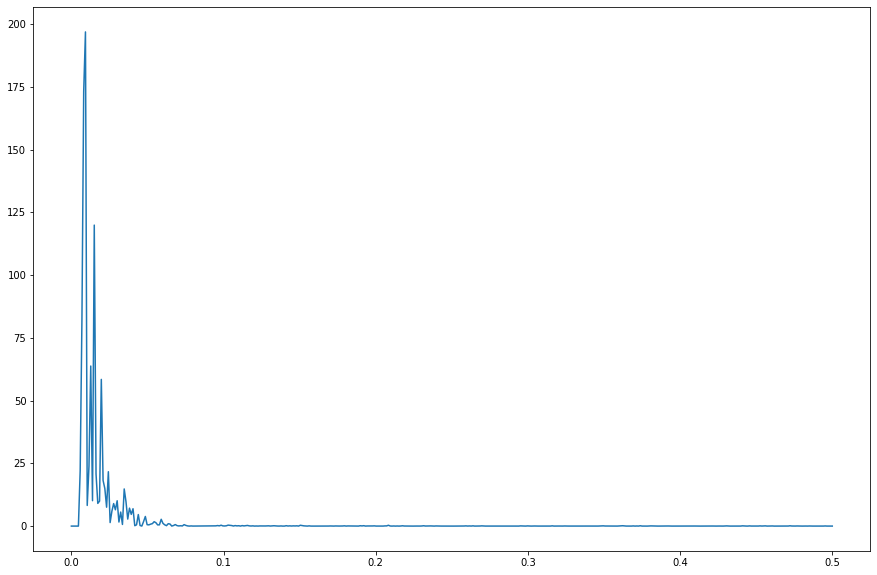

In [302]:
f, Pxx_den=sp.signal.periodogram(serie_ciclos_1)
plt.plot(f, Pxx_den)
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

In [303]:
periodos = pd.DataFrame({'f': f, 'valor': Pxx_den}).sort_values(by = 'valor', ascending=False).head(4).loc[:,'f']
periodos

8     0.009259
7     0.008102
13    0.015046
6     0.006944
Name: f, dtype: float64

In [304]:
cos1, cos2, cos3, cos4 = [np.cos(2*np.pi*np.arange(1,len(serie['UNRATE'])+1)/(1/periodo)) for periodo in periodos]
sen1, sen2, sen3, sen4 = [np.sin(2*np.pi*np.arange(1,len(serie['UNRATE'])+1)/(1/periodo)) for periodo in periodos]
ciclo_modelado=np.column_stack((cos1, cos2, cos3, cos4, sen1, sen2, sen3, sen4))
linmodel_ciclo = sm.OLS(serie_ciclos_1, ciclo_modelado)
results_ciclo_2 = linmodel_ciclo.fit()
print(results_ciclo_2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              2.124
Date:                Wed, 28 Jul 2021   Prob (F-statistic):                      0.0314
Time:                        20:41:29   Log-Likelihood:                         -2741.2
No. Observations:                 864   AIC:                                      5498.
Df Residuals:                     856   BIC:                                      5536.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

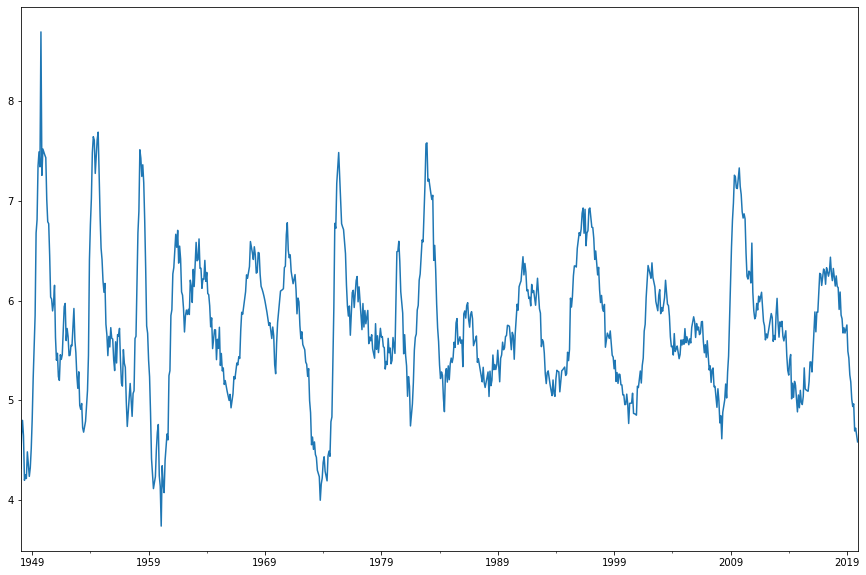

In [305]:
serie_ciclos_2 = serie_ciclos_1 - results_ciclo_2.fittedvalues
serie_ciclos_2.plot()

11
0.01273148148148148


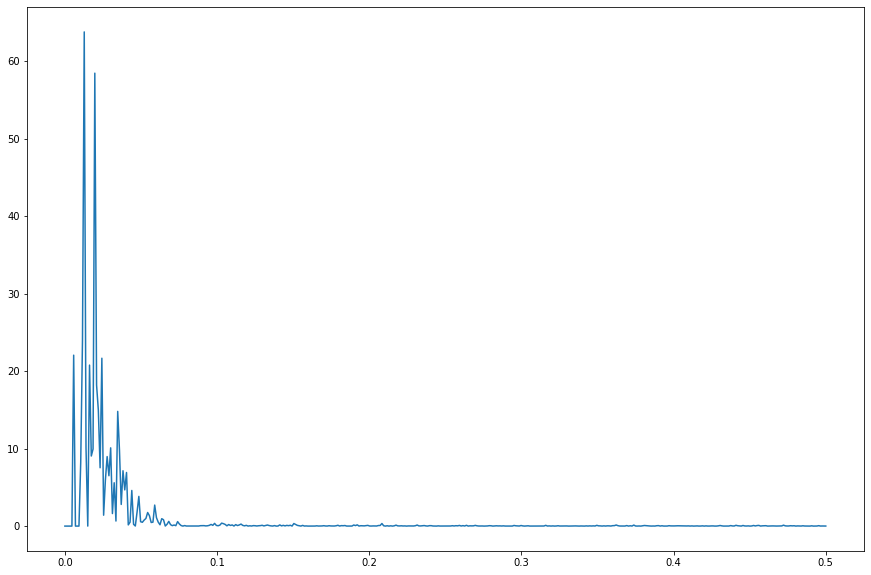

In [306]:
f, Pxx_den=sp.signal.periodogram(serie_ciclos_2)
plt.plot(f, Pxx_den)
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

In [307]:
periodos = pd.DataFrame({'f': f, 'valor': Pxx_den}).sort_values(by = 'valor', ascending=False).head(4).loc[:,'f']
periodos

11    0.012731
17    0.019676
10    0.011574
5     0.005787
Name: f, dtype: float64

In [308]:
cos1, cos2, cos3, cos4 = [np.cos(2*np.pi*np.arange(1,len(serie['UNRATE'])+1)/(1/periodo)) for periodo in periodos]
sen1, sen2, sen3, sen4 = [np.sin(2*np.pi*np.arange(1,len(serie['UNRATE'])+1)/(1/periodo)) for periodo in periodos]
ciclo_modelado=np.column_stack((cos1, cos2, cos3, cos4, sen1, sen2, sen3, sen4))
linmodel_ciclo = sm.OLS(serie['UNRATE'], ciclo_modelado)
results_ciclo_3 = linmodel_ciclo.fit()
print(results_ciclo_3.summary())

                                 OLS Regression Results                                
Dep. Variable:                 UNRATE   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.5885
Date:                Wed, 28 Jul 2021   Prob (F-statistic):                       0.788
Time:                        20:41:30   Log-Likelihood:                         -2766.7
No. Observations:                 864   AIC:                                      5549.
Df Residuals:                     856   BIC:                                      5587.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Esta serie en principio mostraba varios ciclos estadísticamente significativos cuando se realizaba una regresión tomando el ciclo. Los períodogramas mostraron valores altos en frecuencias bajas y se decidió modelar iterativamente quitando los componentes cíclicos hasta que estos dejaran de ser significativos.

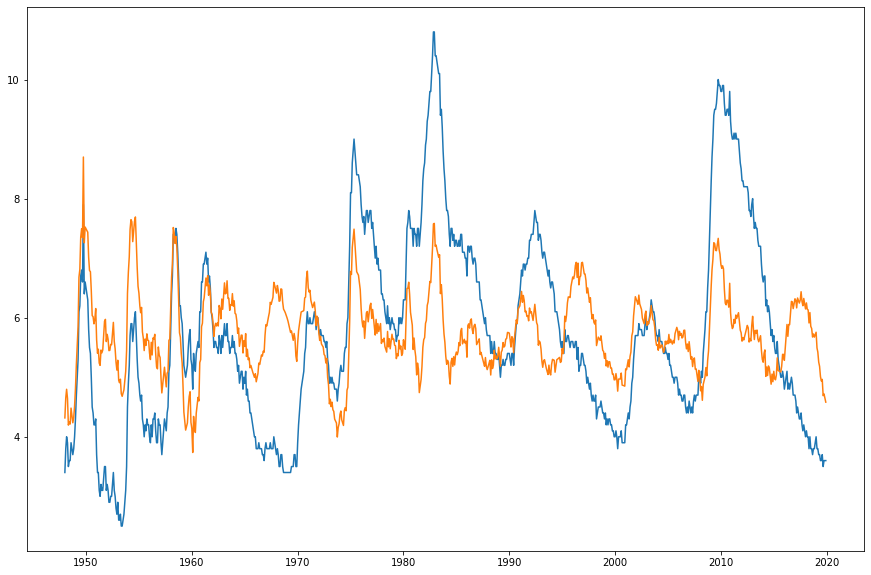

In [309]:
plt.plot(serie)
plt.plot(serie_ciclos_2)

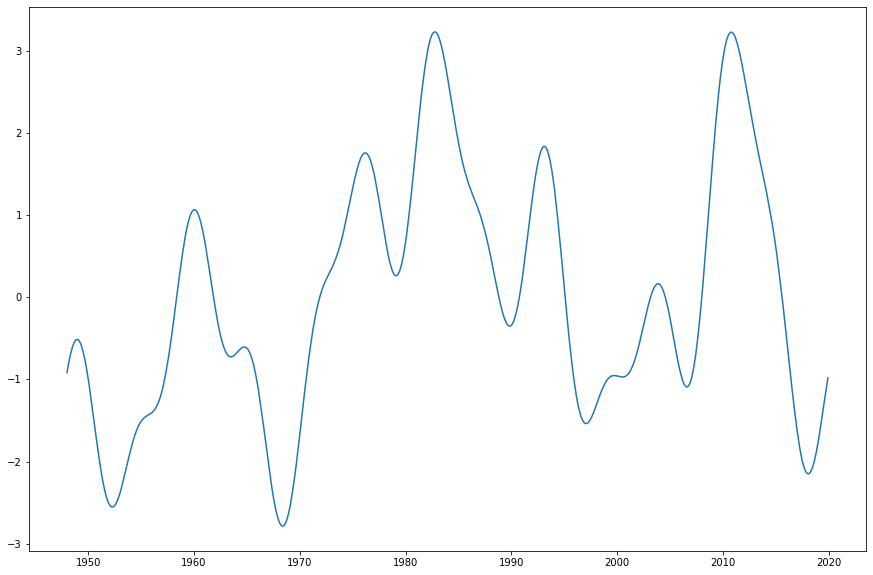

In [310]:
plt.plot(serie['UNRATE'] - serie_ciclos_2)

La serie en naranja será utilizada para ajustar los modelos, ya que ya no se contempla un ciclo estacional que sea estadísticamente significativo, por lo que puede concluirse que esta serie ya no presenta un ciclo como tal. También se procedió a graficar el ciclo resultante de las regresiones.

### Serie Diferenciada.


13
0.015063731170336037


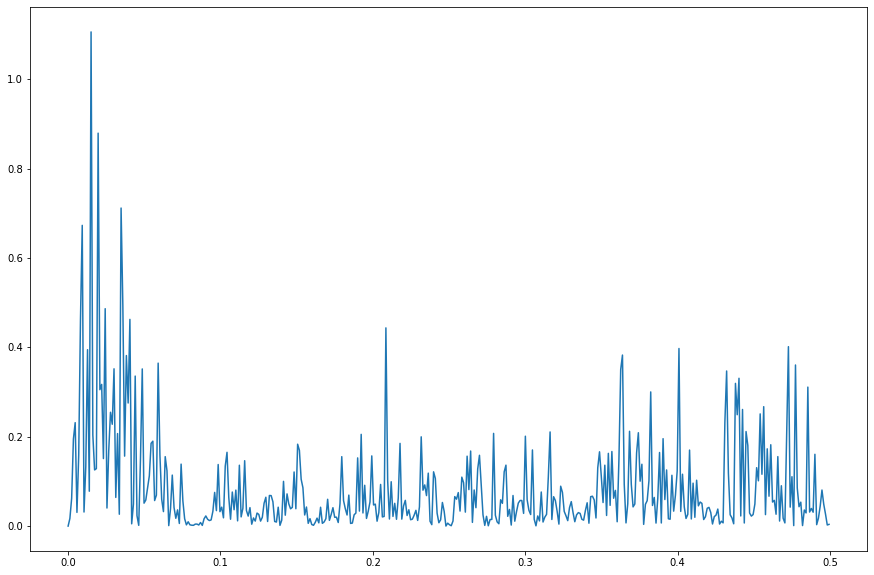

In [311]:
f, Pxx_den=sp.signal.periodogram(serie_diff['UNRATE'][1:])
plt.plot(f, Pxx_den)
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

In [312]:
periodos = pd.DataFrame({'f': f, 'valor': Pxx_den}).sort_values(by = 'valor', ascending=False).head(4).loc[:,'f']
periodos

13    0.015064
17    0.019699
30    0.034762
8     0.009270
Name: f, dtype: float64

In [313]:
cos1, cos2, cos3, cos4 = [np.cos(2*np.pi*np.arange(1,len(serie_diff['UNRATE'][1:])+1)/(1/periodo)) for periodo in periodos]
sen1, sen2, sen3, sen4 = [np.sin(2*np.pi*np.arange(1,len(serie_diff['UNRATE'][1:])+1)/(1/periodo)) for periodo in periodos]
ciclo_modelado=np.column_stack((cos1, cos2, cos3, cos4, sen1, sen2, sen3, sen4))
linmodel_ciclo = sm.OLS(serie_diff['UNRATE'][1:], ciclo_modelado)
results_ciclo_1 = linmodel_ciclo.fit()
print(results_ciclo_3.summary())

                                 OLS Regression Results                                
Dep. Variable:                 UNRATE   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.5885
Date:                Wed, 28 Jul 2021   Prob (F-statistic):                       0.788
Time:                        20:41:30   Log-Likelihood:                         -2766.7
No. Observations:                 864   AIC:                                      5549.
Df Residuals:                     856   BIC:                                      5587.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

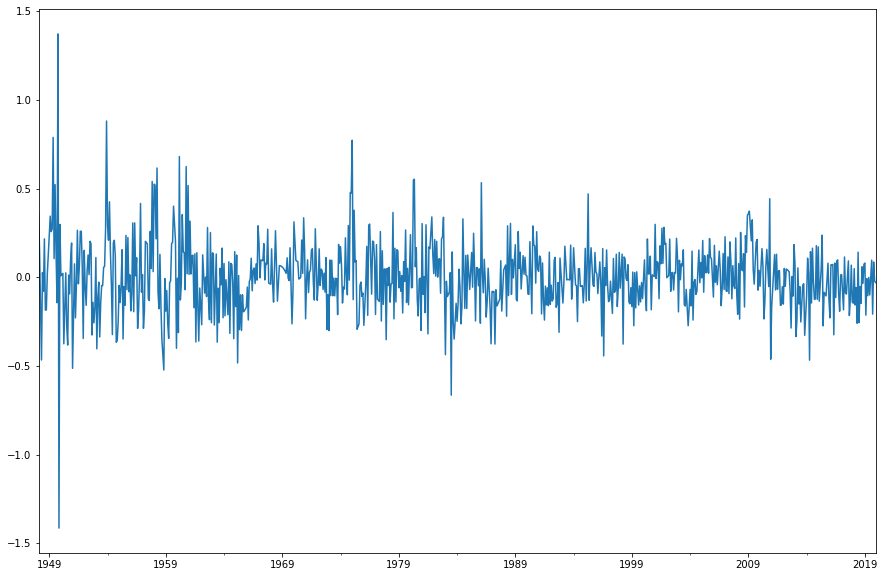

In [314]:
serie_ciclos_1 = serie_diff['UNRATE'][1:] - results_ciclo_1.fittedvalues
serie_ciclos_1.plot()

31
0.03592120509849363


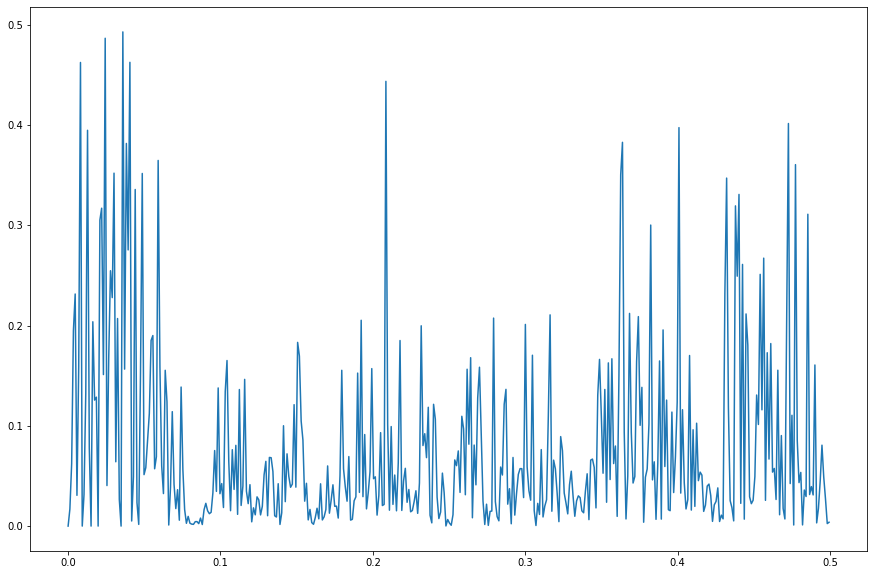

In [315]:
f, Pxx_den=sp.signal.periodogram(serie_ciclos_1)
plt.plot(f, Pxx_den)
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

In [316]:
serie = serie_ciclos_2

In [317]:
serie_diff = serie_ciclos_1

En el caso de la serie diferenciada, sólo es necesario realizar una modelación del ciclo, ya que sólo presenta unos pocos. Al igual que la serie original, se hará uso de esta para poder ajustar los modelos sin tener la preocupación de los ciclos.

# Modelación 

## Nueva Partición Train-Test

In [318]:
X_diff = pd.DataFrame()
for i in range(12,0,-1):
    X_diff[['t-'+str(i)]] = pd.DataFrame(serie_diff).shift(i)

X_diff = X_diff[13:]

X = pd.DataFrame()
for i in range(12,0,-1):
    X[['t-'+str(i)]] = pd.DataFrame(serie).shift(i)

X = X[12:]

print(X_diff)

                t-12      t-11      t-10       t-9       t-8       t-7  \
1949-03-01  0.150933 -0.158319 -0.466880  0.025709 -0.080128  0.215983   
1949-04-01 -0.158319 -0.466880  0.025709 -0.080128  0.215983 -0.185658   
1949-05-01 -0.466880  0.025709 -0.080128  0.215983 -0.185658 -0.184831   
1949-06-01  0.025709 -0.080128  0.215983 -0.185658 -0.184831  0.018587   
1949-07-01 -0.080128  0.215983 -0.185658 -0.184831  0.018587  0.124622   
...              ...       ...       ...       ...       ...       ...   
2019-08-01 -0.052557 -0.147359  0.058823 -0.034357  0.072723  0.079666   
2019-09-01 -0.147359  0.058823 -0.034357  0.072723  0.079666 -0.213923   
2019-10-01  0.058823 -0.034357  0.072723  0.079666 -0.213923 -0.008417   
2019-11-01 -0.034357  0.072723  0.079666 -0.213923 -0.008417 -0.104148   
2019-12-01  0.072723  0.079666 -0.213923 -0.008417 -0.104148 -0.001393   

                 t-6       t-5       t-4       t-3       t-2       t-1  
1949-03-01 -0.185658 -0.184831  0.0185

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, serie.values[12:], test_size = 0.2, shuffle = False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(681, 12) (171, 12) (681,) (171,)


In [320]:
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(X_diff, serie_diff.values[13:], test_size = 0.2, shuffle = False)
print(X_train_diff.shape, X_test_diff.shape, y_train_diff.shape, y_test_diff.shape)

(680, 12) (170, 12) (680,) (170,)


In [321]:
serie.to_excel(r'E:\PERSONAL\UN\Maestría Estadística\1. Primer Semestre\3. Teoría de Series de Tiempo Univariadas\Trabajo Final\Serie_No_Ciclos.xlsx', index = True)
serie_diff.to_excel(r'E:\PERSONAL\UN\Maestría Estadística\1. Primer Semestre\3. Teoría de Series de Tiempo Univariadas\Trabajo Final\Serie_diff_No_Ciclos.xlsx', index = True)


## Árbol de Decisión (Serie sin diferencias)

In [322]:
pipeline = Pipeline([
    ('model', DecisionTreeRegressor(random_state=200))
])

parameters = {
    'model__splitter': ("best", "random"),
    'model__criterion': ("mse", "mae", 'friedman_mse'),
    'model__max_depth': [4,5,6,7,8]
}

grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv = 2,
                           verbose = 3)

In [323]:
grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] model__criterion=mse, model__max_depth=4, model__splitter=best ..
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=best, score=0.839, total=   0.0s
[CV] model__criterion=mse, model__max_depth=4, model__splitter=best ..
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=best, score=0.854, total=   0.0s
[CV] model__criterion=mse, model__max_depth=4, model__splitter=random 
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=random, score=0.797, total=   0.0s
[CV] model__criterion=mse, model__max_depth=4, model__splitter=random 
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=random, score=0.823, total=   0.0s
[CV] model__criterion=mse, model__max_depth=5, model__splitter=best ..
[CV]  model__criterion=mse, model__max_depth=5, model__splitter=best, score=0.836, total=   0.0s
[CV] model__criterion=mse, model__max_depth=5, model__splitter=best ..
[CV]  model__criterion=m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] model__criterion=mae, model__max_depth=7, model__splitter=best ..
[CV]  model__criterion=mae, model__max_depth=7, model__splitter=best, score=0.823, total=   0.0s
[CV] model__criterion=mae, model__max_depth=7, model__splitter=random 
[CV]  model__criterion=mae, model__max_depth=7, model__splitter=random, score=0.757, total=   0.0s
[CV] model__criterion=mae, model__max_depth=7, model__splitter=random 
[CV]  model__criterion=mae, model__max_depth=7, model__splitter=random, score=0.796, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, model__splitter=best ..
[CV]  model__criterion=mae, model__max_depth=8, model__splitter=best, score=0.787, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, model__splitter=best ..
[CV]  model__criterion=mae, model__max_depth=8, model__splitter=best, score=0.809, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, model__splitter=random 
[CV]  model__criterion=mae, model__max_depth=8, model__splitter=random, score=0.804,

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.2s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                       

In [324]:
print(f"Mejor Score: {grid_search.best_score_}")
print("Mejor Configuración de parámetros")

best_parameters = grid_search.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")


Mejor Score: 0.8527164425801694
Mejor Configuración de parámetros
	model__criterion: mae
	model__max_depth: 4
	model__splitter: best


Luego del entrenamiento, los parámetros que la validación cruzada identificó fueron: Criterio mae, máxima profundidad del árbol, y divisor "mejor", en lugar del aleatorio. 

In [325]:
model_tree = DecisionTreeRegressor(criterion = "mae", splitter = "best", max_depth = 4, random_state = 200)

In [326]:
fitting_tree = model_tree.fit(X_train,y_train).predict(X_test)

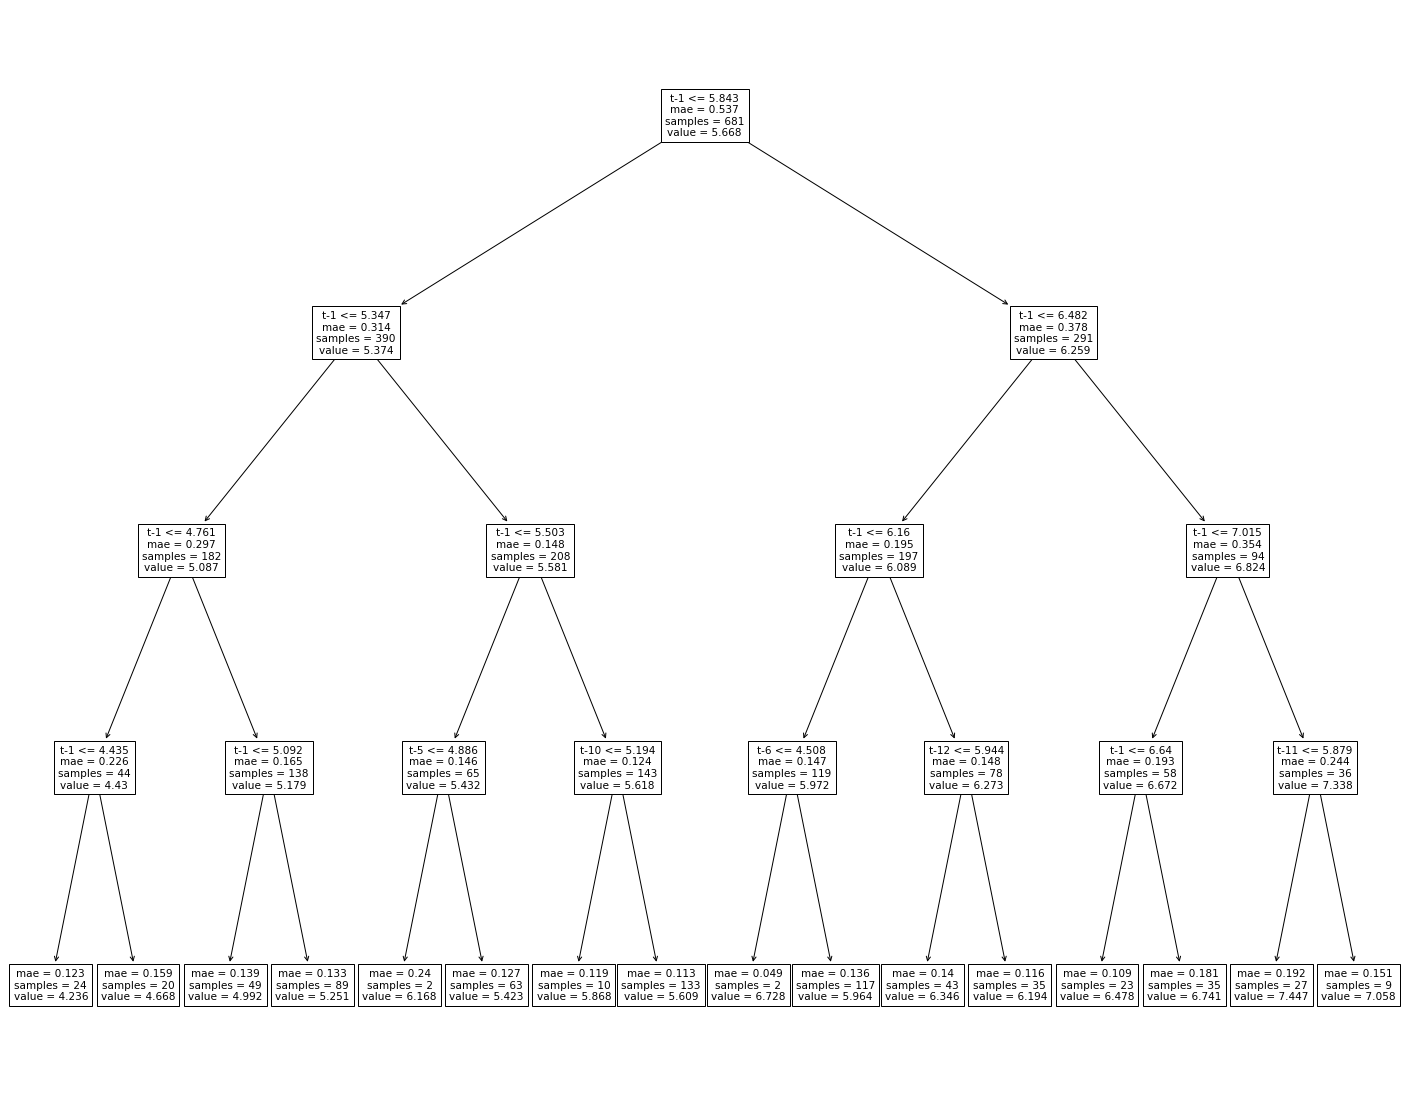

In [327]:
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(model_tree,
                  feature_names = X.columns)

En particular, este árbol de decisión al tener una baja profundidad, es mucho más simple y permite tener una adecuada interpretación de los resultados obtenidos 

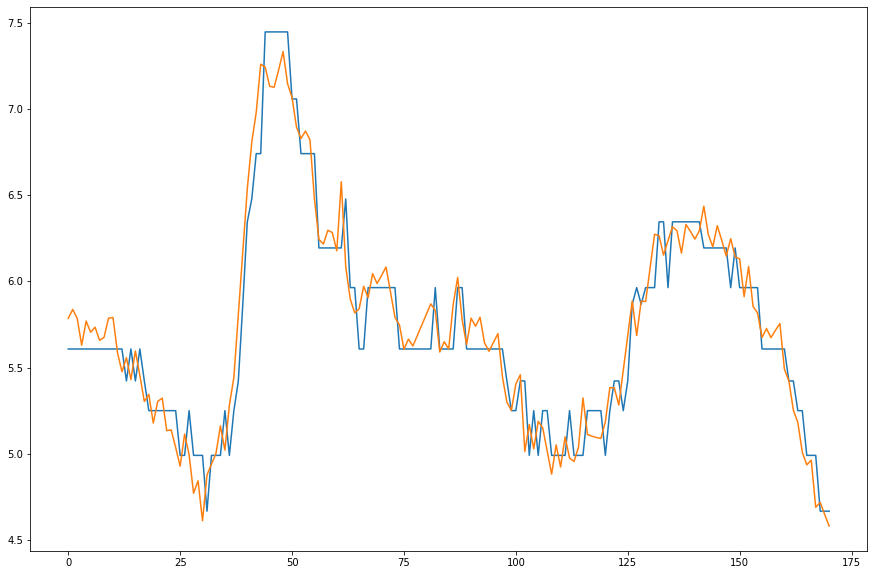

In [328]:
plt.plot(fitting_tree)
plt.plot(y_test)

El modelo ajusta relativamente bien, a pesar de que las particiones son pocas y parece un poco rudimentario el ajuste. Se espera que se mejore este ajuste en los modelos posteriores más complejos.

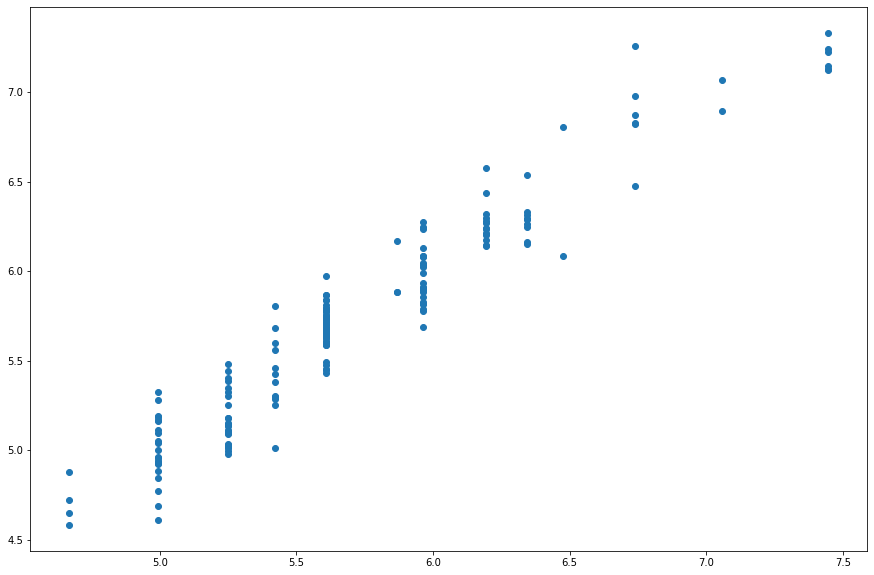

In [329]:
plt.scatter(fitting_tree, y_test)

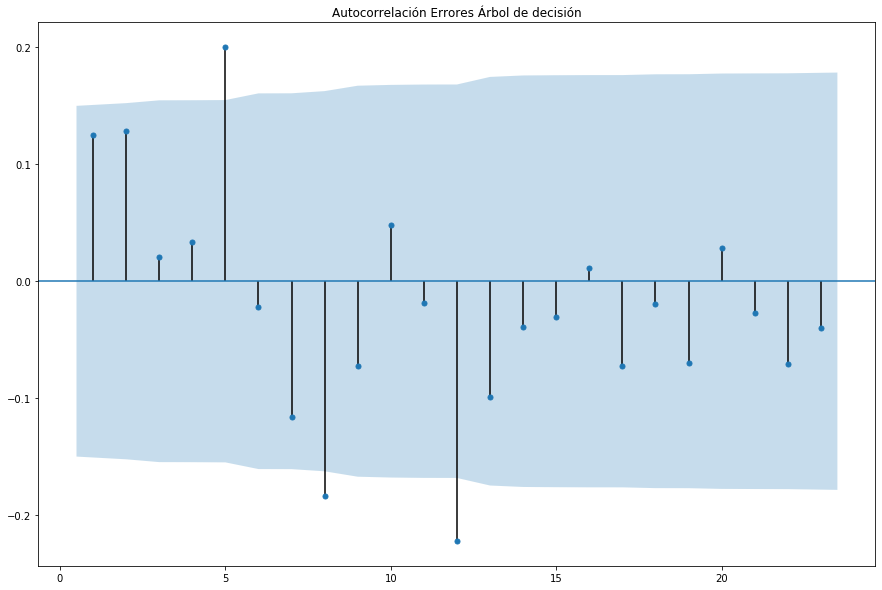

In [330]:
_=plot_acf(y_test.reshape(171,) - fitting_tree, zero = False, title = 'Autocorrelación Errores Árbol de decisión')

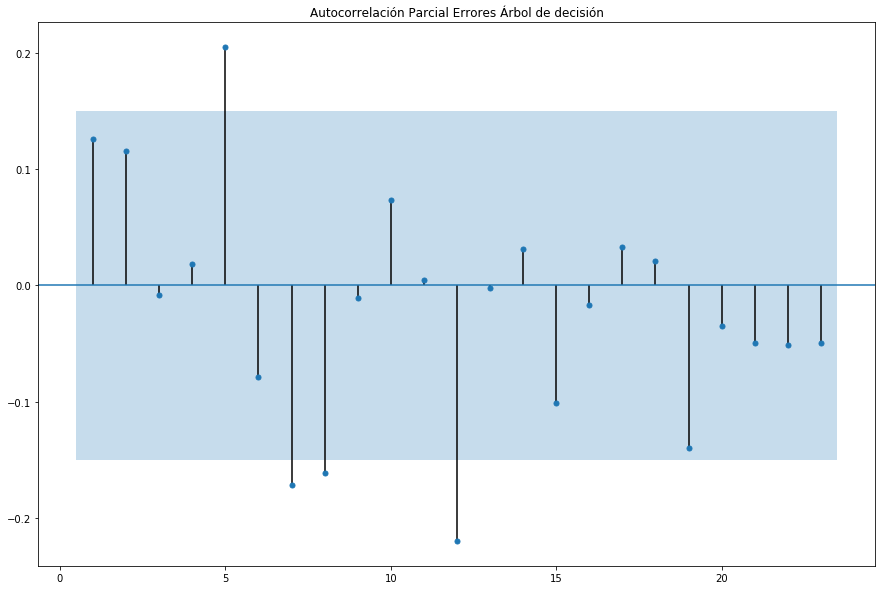

In [331]:
_=plot_pacf(y_test.reshape(171,) - fitting_tree, zero = False, title = 'Autocorrelación Parcial Errores Árbol de decisión')

Tanto la autocorrelación como la autocorrelación parcial son correctas antes del rezago 5, sin embargo, en este rezago, encontramos evidencia estadística de que son significativas, pero no con valores muy altos. Se tendría que entrar a chequear sí es posible añadir covariables que permitan corregir estos errores.

In [332]:
# Score del modelo
model_tree_score = model_tree.score(X_test, y_test)

In [333]:
# R cuadrado del modelo
model_tree_r = np.sum((fitting_tree - np.mean(y_test))**2)/np.sum((y_test - np.mean(y_test))**2)

In [334]:
# Normalidad de los errores
model_tree_norm = jarque_bera(y_test - fitting_tree)[1]

In [335]:
modelos = pd.DataFrame({'Modelo':['Árbol de Decisión (Serie Original)'],
                        'Score': [model_tree_score],
                        'R2': [model_tree_r],
                        'Normalidad': [model_tree_norm]})

## Árbol de Decisión serie diferenciada

In [336]:
pipeline = Pipeline([
    ('model', DecisionTreeRegressor(random_state=200))
])

parameters = {
    'model__splitter': ("best", "random"),
    'model__criterion': ("mse", "mae", 'friedman_mse'),
    'model__max_depth': [4,5,6,7,8]
}

grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv = 2,
                           verbose = 3)

In [337]:
grid_search.fit(X_train_diff,y_train_diff)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] model__criterion=mse, model__max_depth=4, model__splitter=best ..
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=best, score=-0.204, total=   0.0s
[CV] model__criterion=mse, model__max_depth=4, model__splitter=best ..
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=best, score=-0.108, total=   0.0s
[CV] model__criterion=mse, model__max_depth=4, model__splitter=random 
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=random, score=-0.018, total=   0.0s
[CV] model__criterion=mse, model__max_depth=4, model__splitter=random 
[CV]  model__criterion=mse, model__max_depth=4, model__splitter=random, score=-0.030, total=   0.0s
[CV] model__criterion=mse, model__max_depth=5, model__splitter=best ..
[CV]  model__criterion=mse, model__max_depth=5, model__splitter=best, score=-0.243, total=   0.0s
[CV] model__criterion=mse, model__max_depth=5, model__splitter=best ..
[CV]  model__criter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  model__criterion=mae, model__max_depth=7, model__splitter=best, score=-0.827, total=   0.0s
[CV] model__criterion=mae, model__max_depth=7, model__splitter=random 
[CV]  model__criterion=mae, model__max_depth=7, model__splitter=random, score=-0.055, total=   0.0s
[CV] model__criterion=mae, model__max_depth=7, model__splitter=random 
[CV]  model__criterion=mae, model__max_depth=7, model__splitter=random, score=-0.092, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, model__splitter=best ..
[CV]  model__criterion=mae, model__max_depth=8, model__splitter=best, score=-0.457, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, model__splitter=best ..
[CV]  model__criterion=mae, model__max_depth=8, model__splitter=best, score=-0.718, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, model__splitter=random 
[CV]  model__criterion=mae, model__max_depth=8, model__splitter=random, score=-0.317, total=   0.0s
[CV] model__criterion=mae, model__max_depth=8, mode

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.2s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                       

In [338]:
print(f"Mejor Score: {grid_search.best_score_}")
print("Mejor Configuración de parámetros")

best_parameters = grid_search.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")


Mejor Score: -0.0035818088994675756
Mejor Configuración de parámetros
	model__criterion: mae
	model__max_depth: 4
	model__splitter: random


En comparación con el modelo anterior, encontramos que el mejor divisor es el aleatorio, sin embargo es preocupante ver que el score de la validación cruzada es negativo, por lo que el modelo no se ajustó adecuadamente.

In [339]:
model_tree_diff = DecisionTreeRegressor(criterion = "mae", splitter = "random", max_depth = 4, random_state = 200)

In [340]:
fitting_tree_diff = model_tree_diff.fit(X_train_diff,y_train_diff).predict(X_test_diff)

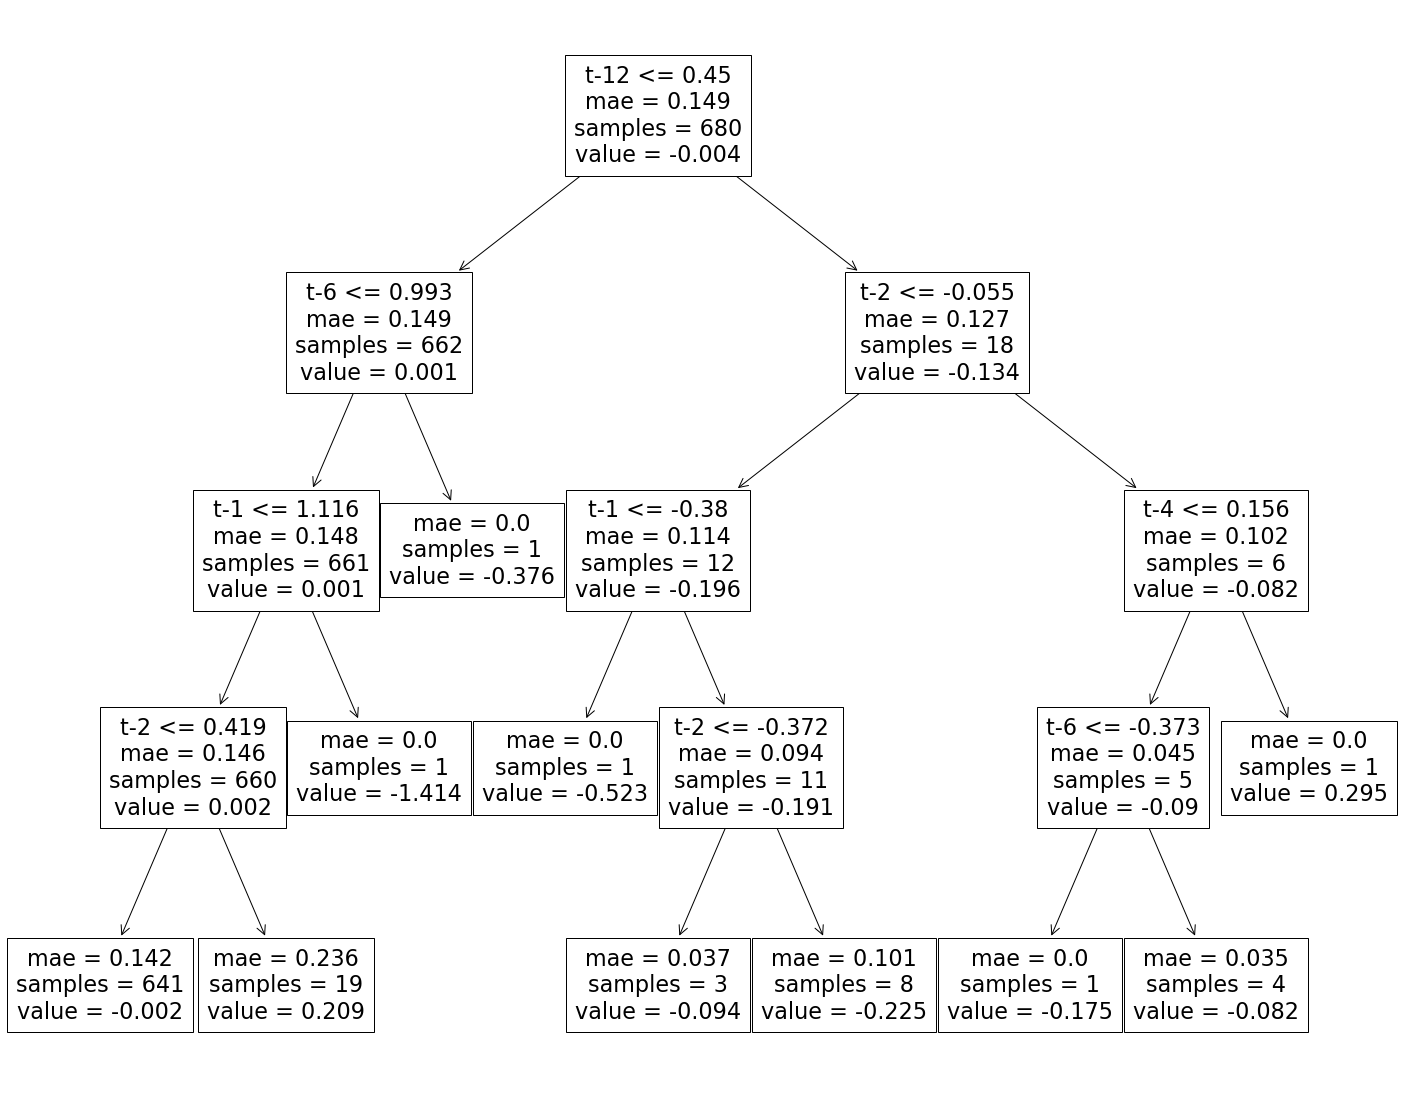

In [341]:
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(model_tree_diff,
                  feature_names = X_diff.columns)

Este arbol de decisión es mucho más simple que el anterior, ya que cuenta con un poco menos de nodos y no todas las particiones llegan hasta la profundidad máxima del árbol

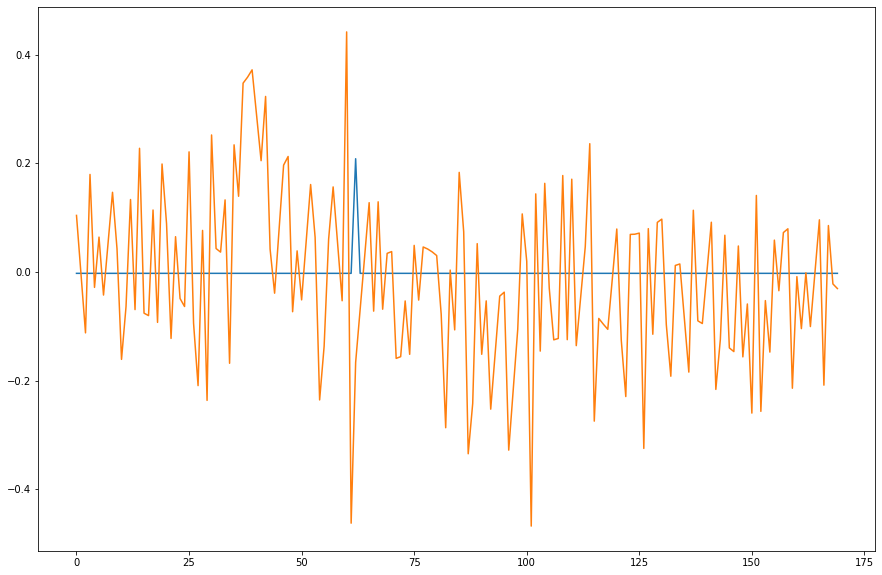

In [342]:
plt.plot(fitting_tree_diff)
plt.plot(y_test_diff)

El modelo no ajustó bien, en parte consideramos que es debido a que la serie se encuentra centrada en 0, afectando los cálculos internos que el modelo hace

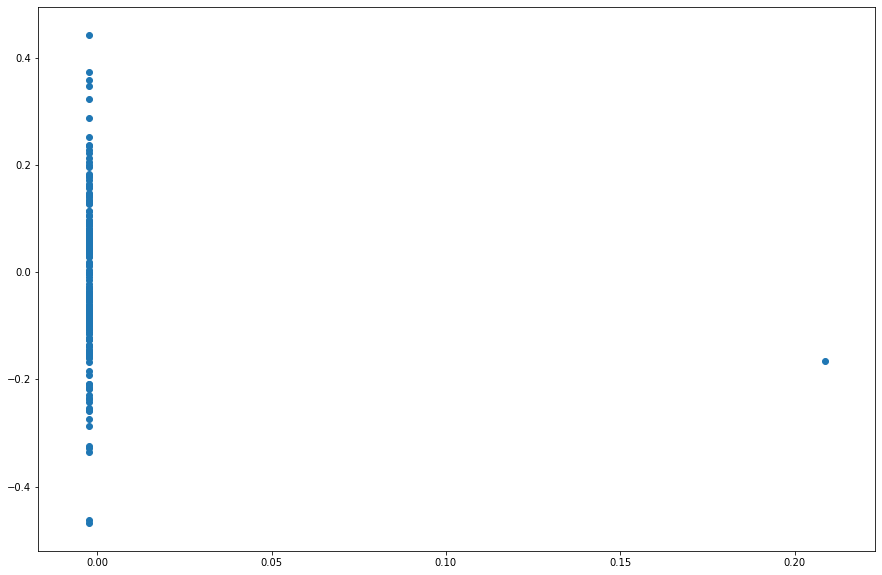

In [343]:
plt.scatter(fitting_tree_diff, y_test_diff)

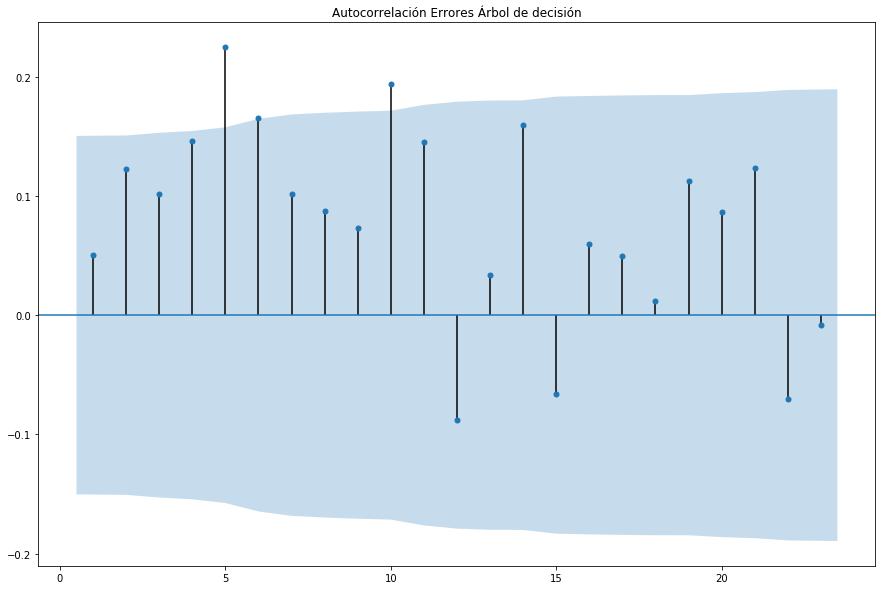

In [344]:
_=plot_acf(y_test_diff.reshape(170,) - fitting_tree_diff, zero = False, title = 'Autocorrelación Errores Árbol de decisión')

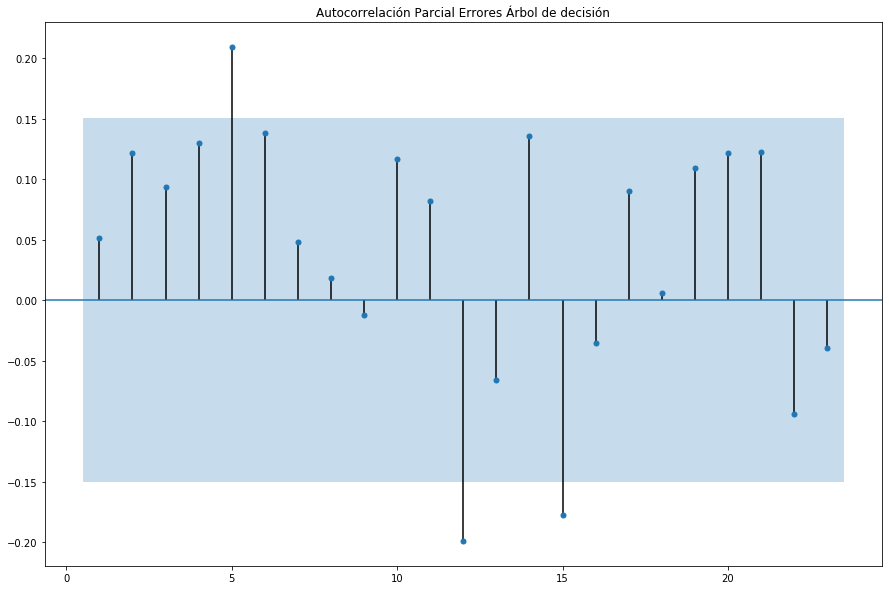

In [345]:
_=plot_pacf(y_test_diff.reshape(170,) - fitting_tree_diff, zero = False, title = 'Autocorrelación Parcial Errores Árbol de decisión')

A pesar de que el ajuste es bastante peor que en el modelo anterior, la autocorrelación de los errores funciona de manera parecida al ser correcta antes del rezago 5, pero en este rezago presentar algunos problemas. En la autocorrelación parcial, resaltan los rezagos 12 y 15, por lo que puede notarse que puede que exista una pequeña estacionalidad no detectada previamente. 
A pesar de esto, no se repite en el rezago 24, por lo que puede deberse a un poco de ruido.

In [346]:
# Score del modelo
model_tree_diff_score = model_tree_diff.score(X_test_diff, y_test_diff)

In [347]:
# R cuadrado del modelo
model_tree_diff_r = np.sum((fitting_tree_diff - np.mean(y_test_diff))**2)/np.sum((y_test_diff - np.mean(y_test_diff))**2)

In [348]:
model_tree_diff_norm = jarque_bera(y_test_diff - fitting_tree_diff)[1]

In [349]:
modelos = modelos.append({'Modelo':'Árbol de Decisión (Serie Diferenciada)',
                        'Score': model_tree_diff_score,
                        'R2': model_tree_diff_r,
                        'Normalidad': model_tree_diff_norm}, ignore_index = True)

## Bosque Aleatorio serie original

In [350]:
pipeline = Pipeline([
    ('model', RandomForestRegressor(n_jobs = -1, random_state=200))
])

parameters = {
    'model__n_estimators': [50, 100, 200],
    'model__criterion': ("mse", "mae"),
    'model__max_depth': [4,5,6,7,8],
    'model__min_samples_split':[2,3,4,5]
}

grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv = 2,
                           verbose = 3)

In [351]:
grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 120 candidates, totalling 240 fits
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50, score=0.857, total=   1.7s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50, score=0.896, total=   0.2s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s



[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100, score=0.856, total=   0.2s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100, score=0.897, total=   0.2s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200, score=0.857, total=   0.3s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200, score=0.897, total=   0.3s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=3, model__n_est

[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=100, score=0.857, total=   0.2s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=100, score=0.900, total=   0.2s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200, score=0.857, total=   0.3s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200, score=0.899, total=   0.3s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=5, model__n_esti

[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=100, score=0.896, total=   0.2s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200, score=0.856, total=   0.3s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200, score=0.894, total=   0.3s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50, score=0.854, total=   0.2s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estima

[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=4, model__n_estimators=200, score=0.857, total=   0.3s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=4, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=4, model__n_estimators=200, score=0.894, total=   0.3s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50, score=0.855, total=   0.2s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50, score=0.894, total=   0.2s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimat

[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=2, model__n_estimators=200, score=0.900, total=   0.3s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50, score=0.859, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50, score=0.901, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100, score=0.859, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimat

[CV]  model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=50, score=0.898, total=   0.2s
[CV] model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=100, score=0.861, total=   0.2s
[CV] model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=100, score=0.897, total=   0.2s
[CV] model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200, score=0.859, total=   0.4s
[CV] model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_estimators=200 
[CV]  model__criterion=mae, model__max_depth=6, model__min_samples_split=5, model__n_esti

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                      

In [352]:
print(f"Mejor Score: {grid_search.best_score_}")
print("Mejor Configuración de parámetros")

best_parameters = grid_search.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")


Mejor Score: 0.8807016128025086
Mejor Configuración de parámetros
	model__criterion: mae
	model__max_depth: 5
	model__min_samples_split: 5
	model__n_estimators: 100


Para este bosque aleatorio, el criterio escogido es mae, la profundidad máxima que los árboles pueden alcanzar es de 5, la mínima cantidad que puede partir para generar un nuevo nodo el algoritmo es de 5 y el número de árboles totales que se van a utilizar es de 100

In [353]:
model_forest = RandomForestRegressor(n_estimators = 100, max_depth = 5, criterion = 'mae', n_jobs = -1, random_state=200)

In [354]:
fitting_forest = model_forest.fit(X_train, y_train).predict(X_test)

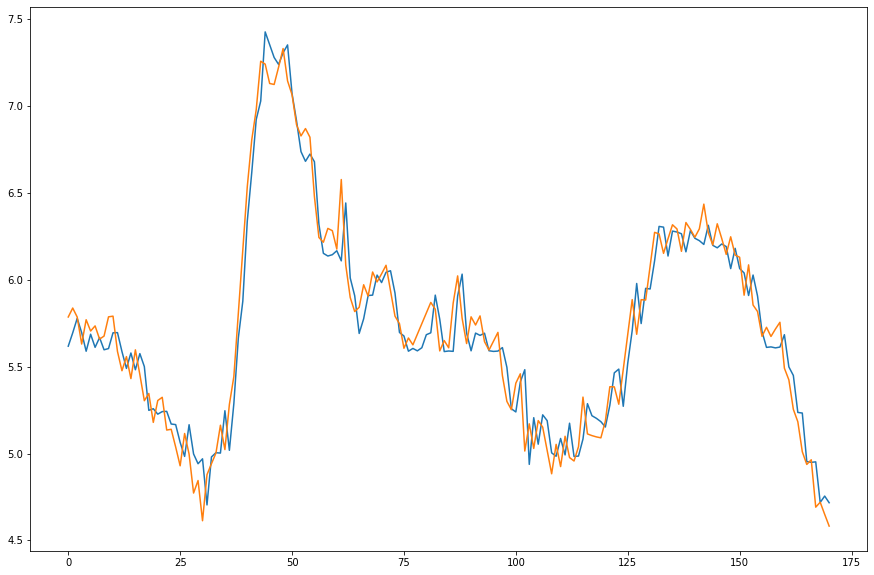

In [355]:
plt.plot(fitting_forest)
plt.plot(y_test)

Se puede ver que el modelo ajusta bastante mejor que el realizado por un sólo estimador de árbol de decisión. Sin embargo, cabe resaltar que este algoritmo es mucho más complejo.

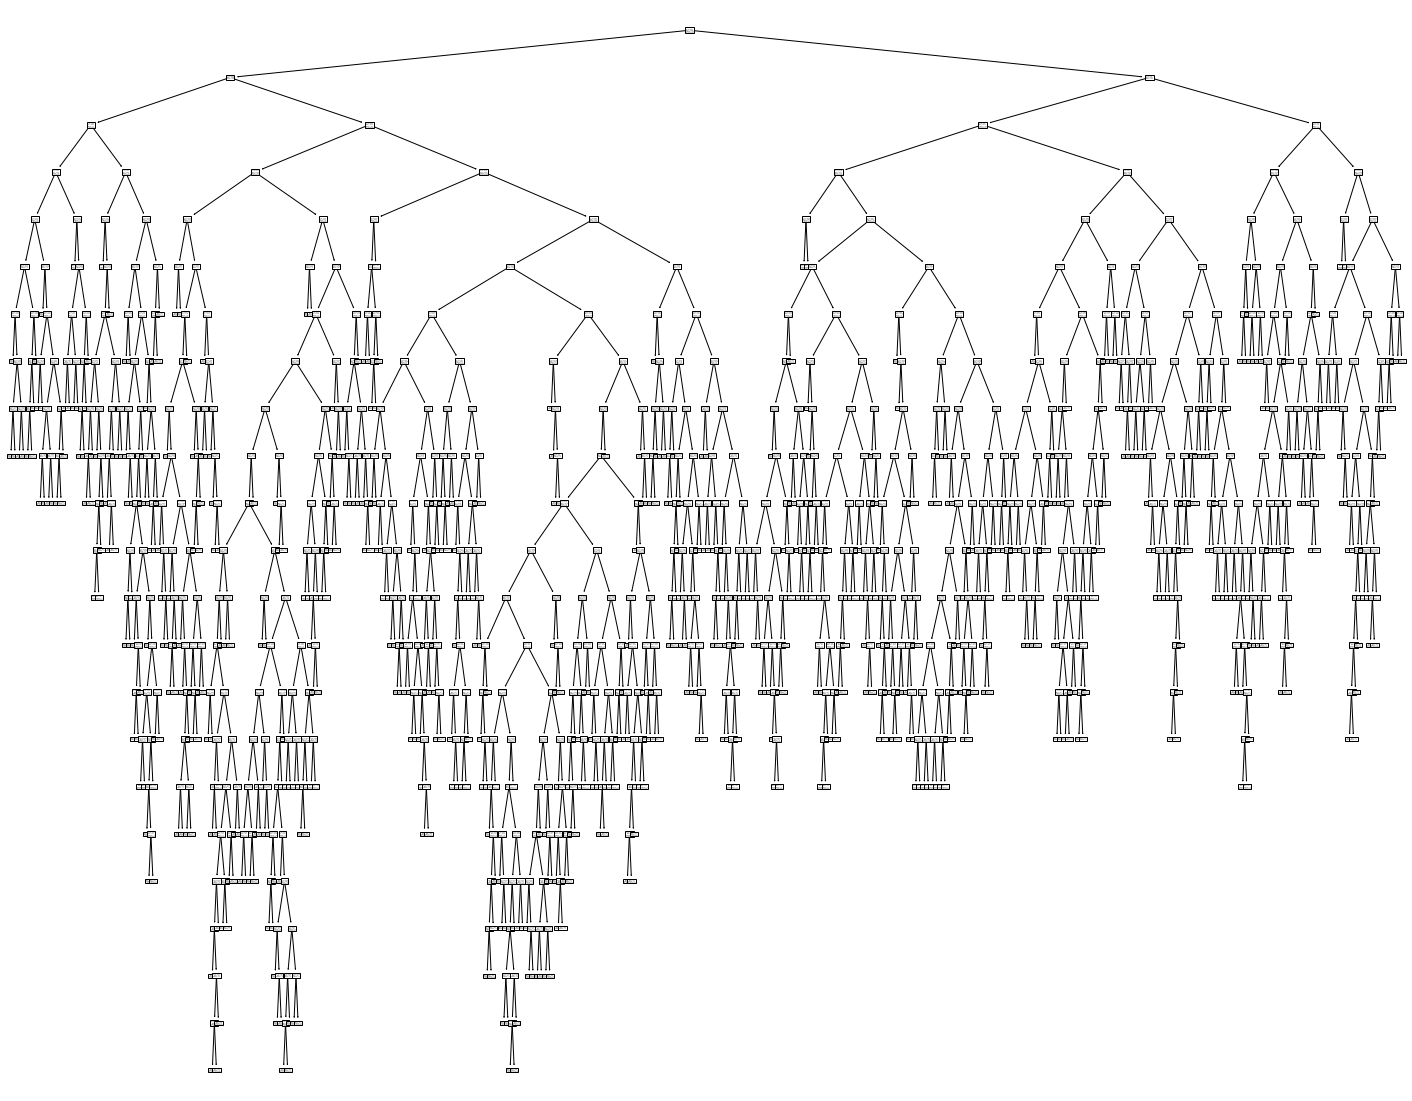

In [356]:
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(model_forest.base_estimator_.fit(X_train,y_train),
                  feature_names = X.columns)

Esta es la representación del estimador base, qué resume el bosque aleatorio completo. Es de resaltar que es mucho más complejo que el árbol individual, pero cumple con la misma función que el mismo; particionar los datos para llegar a un resultado final.

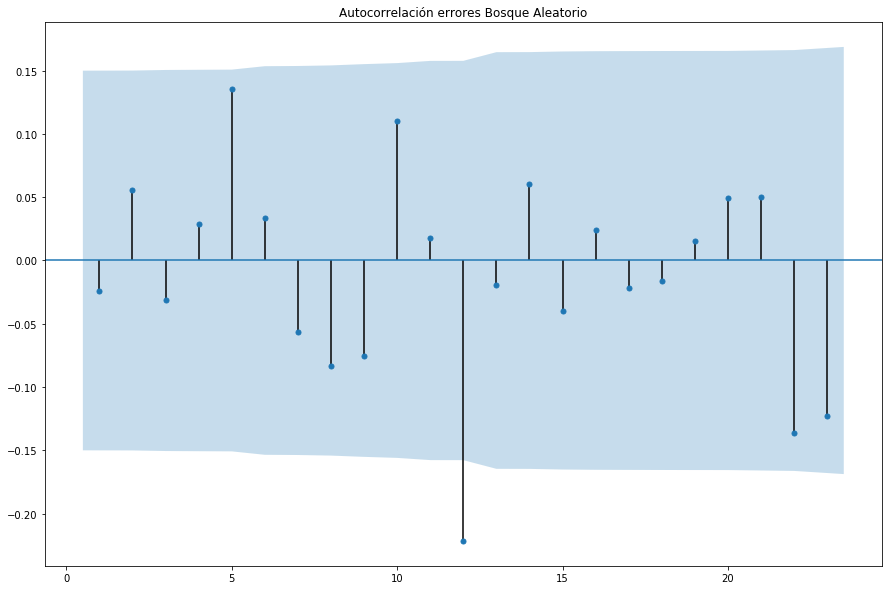

In [357]:
_=plot_acf(y_test.reshape(171,) - fitting_forest, zero = False, title = 'Autocorrelación errores Bosque Aleatorio')

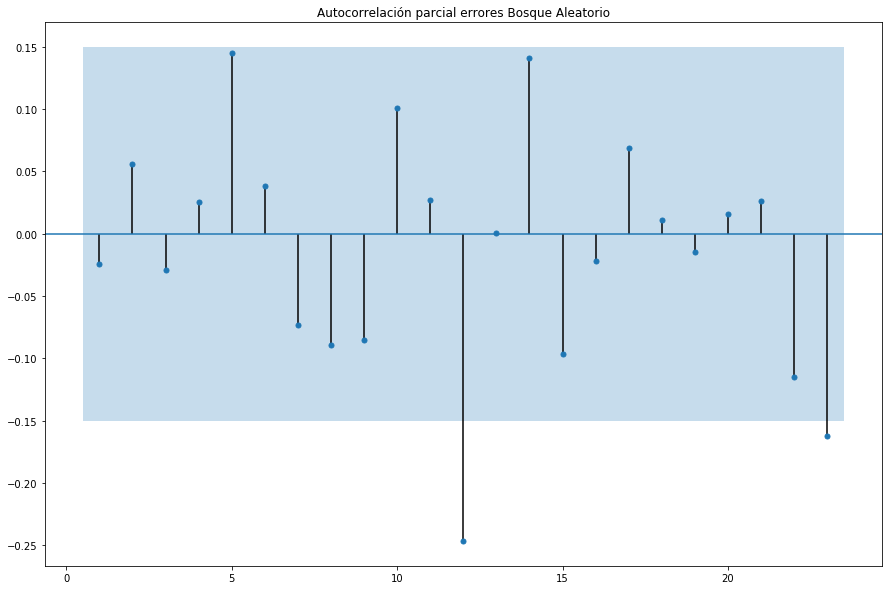

In [358]:
_=plot_pacf(y_test.reshape(171,) - fitting_forest, zero = False, title = 'Autocorrelación parcial errores Bosque Aleatorio')

Sí bien el modelo ajusta de manera correcta, nos encontramos nuevamente con una autocorrelación en el rezago 12, por lo que parece ser que hay una estacionalidad no detectada previamente. También podría corregirse con el uso de covariables adecuadas.

In [359]:
model_forest_score = model_forest.score(X_test, y_test)

In [360]:
# R cuadrado del modelo
model_forest_r = np.sum((fitting_forest - np.mean(y_test))**2)/np.sum((y_test - np.mean(y_test))**2)

In [361]:
# Normalidad de los errores
model_forest_norm = jarque_bera(y_test - fitting_forest)[1]

In [362]:
modelos = modelos.append({'Modelo':'Bosque Aleatorio (Serie Original)',
                        'Score': model_forest_score,
                        'R2': model_forest_r,
                        'Normalidad': model_forest_norm}, ignore_index = True)

## Bosque Aleatorio serie Diferenciada

In [363]:
pipeline = Pipeline([
    ('model', RandomForestRegressor(n_jobs = -1, random_state=200))
])

parameters = {
    'model__n_estimators': [50, 100, 200],
    'model__criterion': ("mse", "mae"),
    'model__max_depth': [4,5,6,7,8],
    'model__min_samples_split':[2,3,4,5]
}

grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv = 2,
                           verbose = 3)

In [364]:
grid_search.fit(X_train_diff,y_train_diff)

Fitting 2 folds for each of 120 candidates, totalling 240 fits
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50, score=0.021, total=   0.2s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=50, score=0.019, total=   0.2s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100, score=0.025, total=   0.2s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=100, score=0.027, total=   0.2s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200, score=0.030, total=   0.3s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=2, model__n_estimators=200, score=0.033, total=   0.3s
[CV] model__criterion=mse, model__max_depth=4, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=4, model__min_samples_split=3, model__n_esti

[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=100, score=0.029, total=   0.2s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200, score=0.026, total=   0.3s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=4, model__n_estimators=200, score=0.033, total=   0.3s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=5, model__n_estimators=50, score=0.022, total=   0.2s
[CV] model__criterion=mse, model__max_depth=5, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=5, model__min_samples_split=5, model__n_estima

[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200, score=0.025, total=   0.3s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=2, model__n_estimators=200, score=0.037, total=   0.3s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50, score=0.023, total=   0.2s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=50, score=0.034, total=   0.2s
[CV] model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=7, model__min_samples_split=3, model__n_estimat

[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=4, model__n_estimators=200, score=0.035, total=   0.3s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50, score=0.007, total=   0.2s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=50, score=0.022, total=   0.2s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=100, score=0.017, total=   0.2s
[CV] model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimators=100 
[CV]  model__criterion=mse, model__max_depth=8, model__min_samples_split=5, model__n_estimat

[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50, score=0.045, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=50, score=0.040, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100, score=0.048, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=100, score=0.047, total=   0.2s
[CV] model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=mae, model__max_depth=5, model__min_samples_split=3, model__n_estima

[CV]  model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=50, score=0.040, total=   0.2s
[CV] model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=50 
[CV]  model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=50, score=0.023, total=   0.2s
[CV] model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=100, score=0.046, total=   0.2s
[CV] model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=100 
[CV]  model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=100, score=0.040, total=   0.3s
[CV] model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estimators=200 
[CV]  model__criterion=mae, model__max_depth=8, model__min_samples_split=3, model__n_estima

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                      

In [365]:
print(f"Mejor Score: {grid_search.best_score_}")
print("Mejor Configuración de parámetros")

best_parameters = grid_search.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")


Mejor Score: 0.04974923341010462
Mejor Configuración de parámetros
	model__criterion: mae
	model__max_depth: 4
	model__min_samples_split: 3
	model__n_estimators: 100


En comparación con el modelo anterior, la profundidad máxima del árbol sugerida es de 4 y el mínimo de muestras requeridas para la partición es de 3. Adicionalmente, ya no se tiene un score negativo, lo que supone una mejoría notable con respecto al modelo anterior, a pesar de que este no supera el 10%

In [366]:
model_forest_diff = RandomForestRegressor(n_estimators = 100, max_depth = 4, 
                                          min_samples_split=3, n_jobs = -1, random_state=200, criterion = 'mae')

In [367]:
fitting_forest_diff = model_forest_diff.fit(X_train_diff, y_train_diff).predict(X_test_diff)

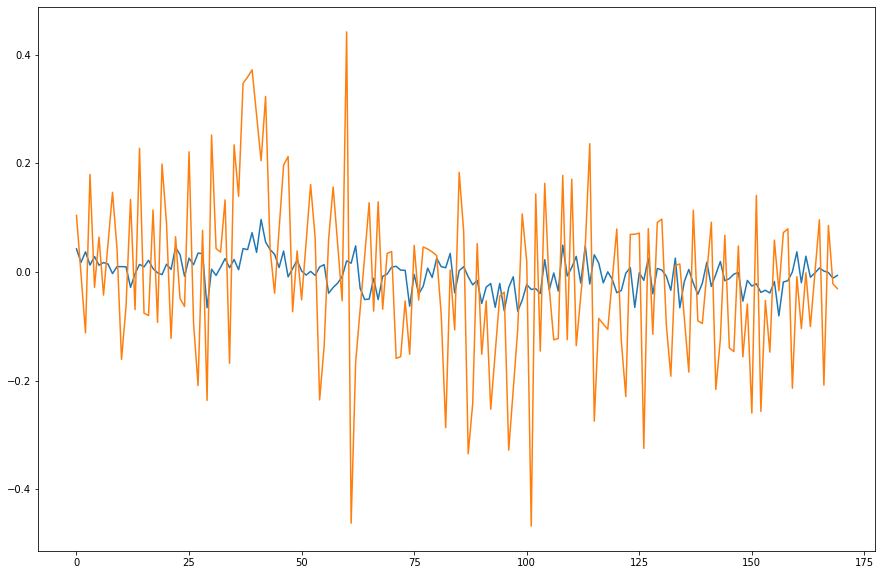

In [368]:
plt.plot(fitting_forest_diff)
plt.plot(y_test_diff)

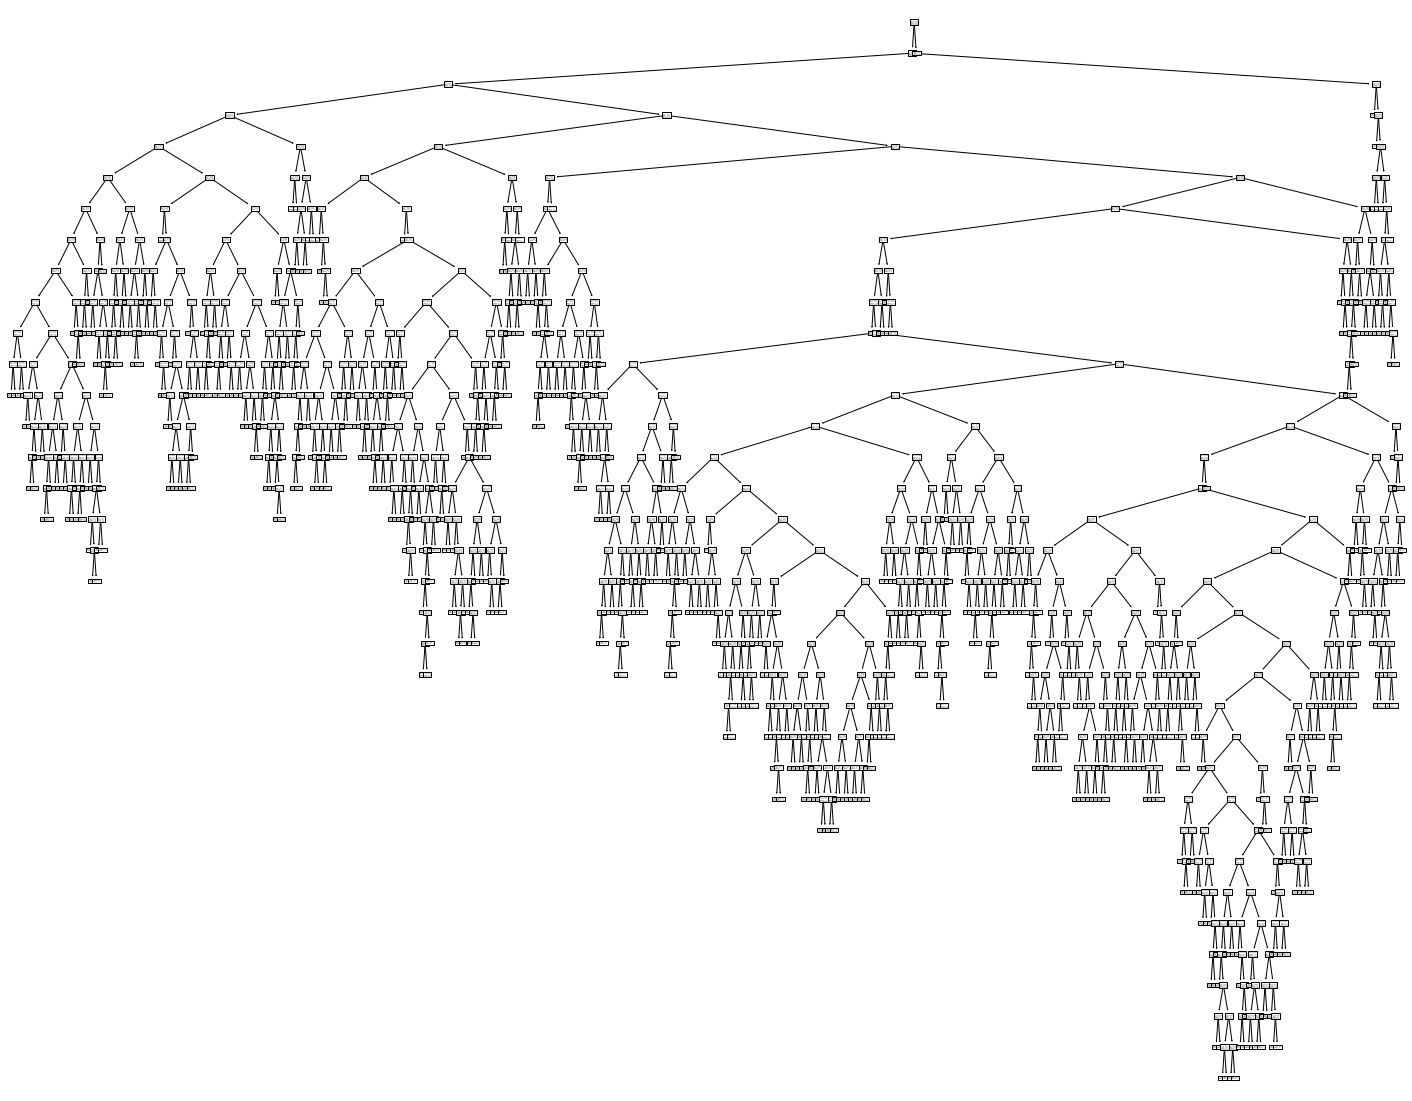

In [369]:
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(model_forest_diff.base_estimator_.fit(X_train_diff,y_train_diff),
                  feature_names = X.columns)

Al igual que el modelo anterior, este es mucho más complejo que los árboles de decisión individuales. Sin embargo, el modelo no ajusta aún de manera correcta los datos, a pesar de que trata de capturar mejor la variación de los mismos.

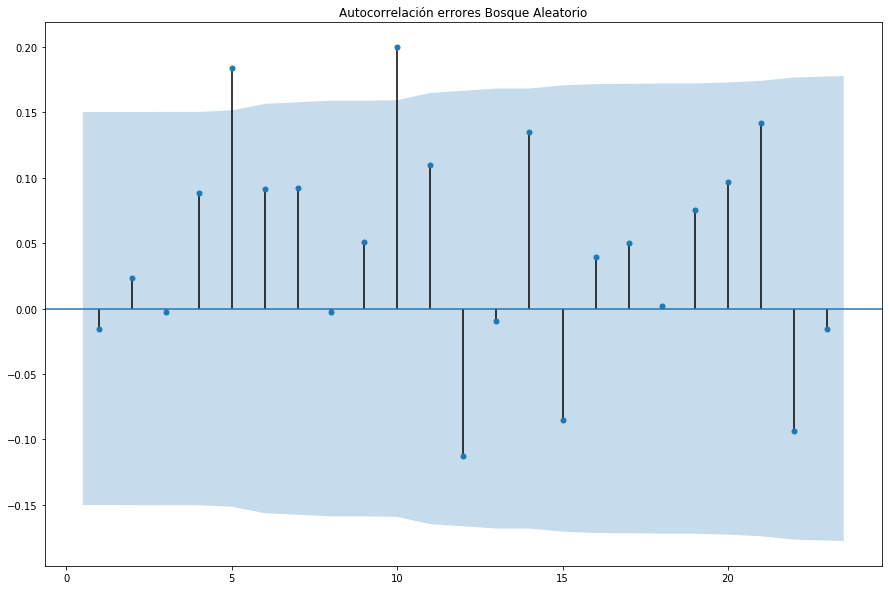

In [370]:
_=plot_acf(y_test_diff.reshape(170,) - fitting_forest_diff, zero = False, title = 'Autocorrelación errores Bosque Aleatorio')

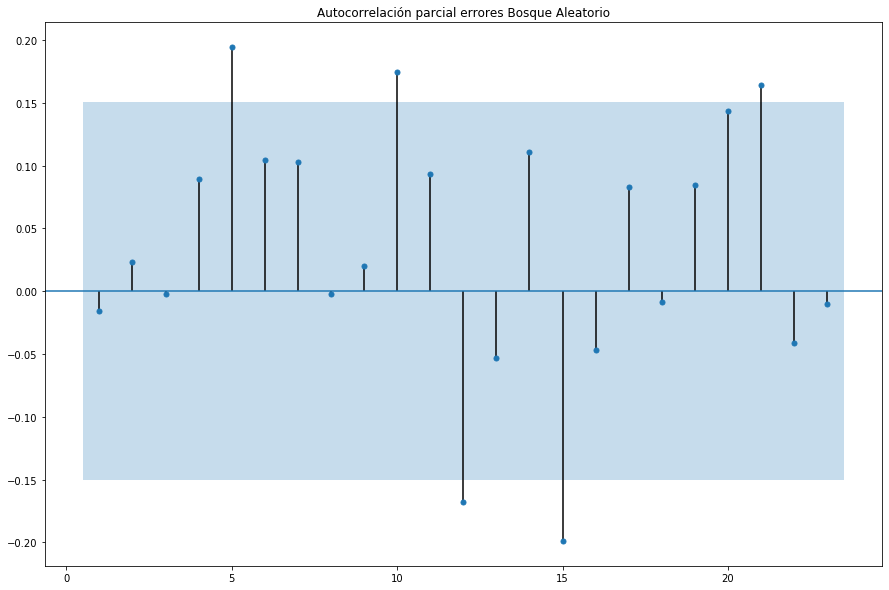

In [371]:
_=plot_pacf(y_test_diff.reshape(170,) - fitting_forest_diff, zero = False, title = 'Autocorrelación parcial errores Bosque Aleatorio')

En este modelo, es posible ver que a pesar de que el ajuste es ligeramente mejor, las funciones de autocorrelación parcial y normal sugieren la existencia de rezagos significativos de orden 5, 10, 12 y 15. Sumado al pobre ajuste del modelo, en este caso se sugiere añadir alguna covariable que permita explicar la significacia estadística de estos rezagos.

In [372]:
model_forest_diff_score = model_forest_diff.score(X_test_diff, y_test_diff)

In [373]:
# R cuadrado del modelo
model_forest_diff_r = np.sum((fitting_forest_diff - np.mean(y_test_diff))**2)/np.sum((y_test_diff - np.mean(y_test_diff))**2)

In [374]:
# Normalidad de los errores
model_forest_diff_norm = jarque_bera(y_test_diff - fitting_forest_diff)[1]

In [375]:
modelos = modelos.append({'Modelo':'Bosque Aleatorio (Serie Diferenciada)',
                        'Score': model_forest_diff_score,
                        'R2': model_forest_diff_r,
                        'Normalidad': model_forest_diff_norm}, ignore_index = True)

## Redes Neuronales para serie original

In [376]:
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=200))
])

parameters = {    
      'model__solver' : ['lbfgs', 'adam', 'sgd'],
      'model__hidden_layer_sizes' : [(10,), (20,), (40,), (80,), (160,), (240,),], 
      'model__activation' : ['identity', 'logistic', 'tanh', 'relu'],
      'model__learning_rate': ['constant', 'adaptive']
}


grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv = 5,
                           verbose = 3)

In [377]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=ide

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.859, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.853, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.893, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.832, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.901, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.845, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.852, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.909, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.913, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), mo

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.853, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.893, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.832, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.901, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.846, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.851, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.909, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,)

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.734, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.803, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.828, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.811, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.908, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.858, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.868, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.887, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.842, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.921, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__lea

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.734, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.803, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.828, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.811, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.908, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.859, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.868, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.889, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.842, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.922, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__lea

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.749, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.849, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.839, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.839, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.921, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.860, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.893, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.895, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__le

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.849, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.839, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.839, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.921, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.861, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.896, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.896, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.886, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__lea

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.936, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,)

[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.896, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.945, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_si

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.721, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.857, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.847, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.874, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.932, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.881, total=   0.3s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.898, total=   0.2s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.907, total=   0.3s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.721, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.857, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.847, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.874, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.932, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.883, total=   0.4s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.906, total=   0.3s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.908, total=   0.4s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.943, total=   0.4s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.2s
[CV] model__activation=identity, model__hidden_layer_size

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.825, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.892, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.903, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.904, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.944, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.875, total=   0.3s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.902, total=   0.3s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.919, total=   0.3s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.825, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.892, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.903, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.904, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.944, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.877, total=   0.4s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.901, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.919, total=   0.5s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\

[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.937, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.887, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.944, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-1.331, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-6.318, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-1.619, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-4.554, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-4.104, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.036, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.009, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.004, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model_

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\

[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.910, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.937, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.887, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.944, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-1.331, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-6.318, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-1.619, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-4.554, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-4.104, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.030, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.106, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), mode

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.915, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.881, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.940, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.887, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.937, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.183, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-1.243, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.110, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.315, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.538, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.230, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.297, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.296, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.329, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.303, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.915, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.881, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.940, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.887, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.937, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.183, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-1.243, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.110, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.315, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.538, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.230, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.297, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.296, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.329, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.303, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.919, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.888, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.939, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.886, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.937, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.018, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=-0.081, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.037, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.309, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.400, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.385, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.402, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.378, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.919, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.888, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.939, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.886, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.937, total=   0.2s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.018, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=-0.081, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,),

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.400, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.385, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.402, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.378, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.915, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.909, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.940, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.890, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.939, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.082, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.428, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.374, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.427, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.438, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.369, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.534, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.476, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.530, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.516, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.915, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.909, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.940, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.890, total=   0.4s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.939, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.082, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.428, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.374, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.427, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.438, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.369, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.534, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.476, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.530, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.516, total=   0.3s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.916, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.911, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.938, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.893, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.940, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.147, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.256, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.209, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(1

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.476, total=   0.6s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.634, total=   0.6s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.569, total=   0.7s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.632, total=   0.7s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.604, total=   0.7s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.916, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.911, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.938, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.893, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.940, total=   0.5s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.147, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.256, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.209, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(1

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.476, total=   0.7s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.634, total=   0.6s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.569, total=   0.7s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.632, total=   0.6s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.604, total=   0.7s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.916, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.911, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.938, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.891, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.941, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.413, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.628, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.550, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.627, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.645, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.522, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.707, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.627, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.709, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.690, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.916, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.911, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.938, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.891, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.941, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.413, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.628, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.550, total=   0.8s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.627, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.645, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.522, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.707, total=   1.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.627, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.709, total=   0.9s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.690, total=   1.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.902, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.935, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.888, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.941, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.076, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.238, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.146, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.199, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.049, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.011, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.154, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.030, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.941, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.076, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-0.238, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.146, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.199, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.049, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.008, total=   0.1s

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.




[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.235, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.012, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.030, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.018, t

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.914, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.940, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.886, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.385, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.607, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.608, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.514, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.530, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.590, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.317, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.578, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.488, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.397, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.914, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.940, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.886, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.385, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.607, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.608, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.514, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.530, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.590, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.317, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.578, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.488, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=sgd, score=0.397, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.916, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.914, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.937, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.885, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.605, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.785, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.733, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.592, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.683, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.611, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.531, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.625, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.507, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.489, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.916, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.914, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.937, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.885, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.934, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.605, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.785, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.733, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.592, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.683, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.611, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.531, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.625, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.507, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.489, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.914, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.895, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.939, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.890, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.938, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.818, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.894, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.905, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.850, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.894, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.741, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.794, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.793, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.726, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.746, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.914, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.895, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.939, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.890, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.938, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.818, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.894, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.905, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.850, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.894, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.741, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.794, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.793, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.726, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.746, total=   0.4s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.918, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.900, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.942, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.891, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.941, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.776, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.896, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.875, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.838, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.885, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.771, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.857, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.831, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.769, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.809, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.918, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.900, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.942, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.891, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.941, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.776, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.896, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.875, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.838, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.885, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.771, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.857, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.831, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.769, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.809, total=   0.7s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.915, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.904, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.940, total=   1.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.889, total=   1.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.941, total=   1.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.851, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.910, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.913, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.861, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.914, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.812, total=   0.6s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.899, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.889, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.841, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.887, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.915, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.904, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.940, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.889, total=   1.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.941, total=   1.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.851, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.910, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.913, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.861, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.914, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.814, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.899, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.889, total=   0.9s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.841, total=   0.8s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.887, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.896, total=   0.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.946, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.605, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.755, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.791, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.770, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.852, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.849, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.834, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.890, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.833, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=0.901, total=   0.1s

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.913, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, sc

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.946, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.605, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.755, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.791, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.770, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.852, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.850, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.836, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__s

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.890, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.838, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=0.905, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.912, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.907, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.897, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.944, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.806, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.882, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.899, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.860, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.927, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=sgd, score=0.834, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model_

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.934, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.897, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.944, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.806, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.882, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.899, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.860, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.927, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, mode

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.915, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.917, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.937, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.893, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=0.947, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.852, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.898, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.897, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.855, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.932, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.842, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.887, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=0.894, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__sol

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.915, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.917, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.937, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.893, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.947, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.852, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.898, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.897, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.855, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.932, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.845, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.894, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.895, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.881, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=0.936, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.909, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.910, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.935, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.896, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=0.945, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.870, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.868, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.908, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.904, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.944, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.870, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.881, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=0.909, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__sol

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.909, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.910, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.935, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.896, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.945, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.870, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.868, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.908, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.904, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.944, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.872, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.894, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.913, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.897, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.946, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.914, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.906, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.934, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.899, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.943, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.850, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.895, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.899, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.895, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.930, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.842, total=   0.5s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.895, total=   0.6s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=sgd, score=0.902, total=   0.6s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, mo

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.914, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.906, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.934, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.899, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.943, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.850, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.895, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.899, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.895, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.930, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.845, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.896, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.903, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.898, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=sgd, score=0.941, total=   0.8s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.911, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.914, total=   1.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.932, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.891, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.947, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.874, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.907, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.916, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.910, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.941, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.848, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.896, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=sgd, score=0.913, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, mo

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.914, total=   1.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.932, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.891, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.947, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.874, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.907, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.916, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.910, total=   0.9s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.941, total=   1.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.849, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.897, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.914, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.901, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  4.0min finished


[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=0.945, total=   1.0s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        MLPRegressor(activation='relu',
                                                     alpha=0.0001,
                                                     batch_size='auto',
                                                     beta_1=0.9, beta_2=0.999,
                                                     early_stopping=False,
                                                     epsilon=1e-08,
                                                     hidden_layer_sizes=(100,),
                                                     learning_rate='constant',
                                                     learning_rate_init=0.001,
                                                     max_fun=15000,
                                                     max_iter=200, momentum=0.9,
                                                  

In [378]:
print(f"Mejor Score: {grid_search.best_score_}")
print("Mejor Configuración de parámetros")

best_parameters = grid_search.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")


Mejor Score: 0.9215449678610493
Mejor Configuración de parámetros
	model__activation: relu
	model__hidden_layer_sizes: (40,)
	model__learning_rate: constant
	model__solver: lbfgs


Para la red neuronal, la función de activación sugerida por la validación cruzada es de ReLU (igual a un máximo entre 0 y x), un tamaño de la capa oculta de 40 neuronas, una tasa de aprendizaje constante y un algoritmo de optimización de tipo LBFGS 

In [379]:
model_nn = MLPRegressor(activation = 'relu', hidden_layer_sizes = (40,), learning_rate = 'constant', 
             solver = 'lbfgs', random_state=200)

In [380]:
fitting_nn = model_nn.fit(X_train, y_train).predict(X_test)

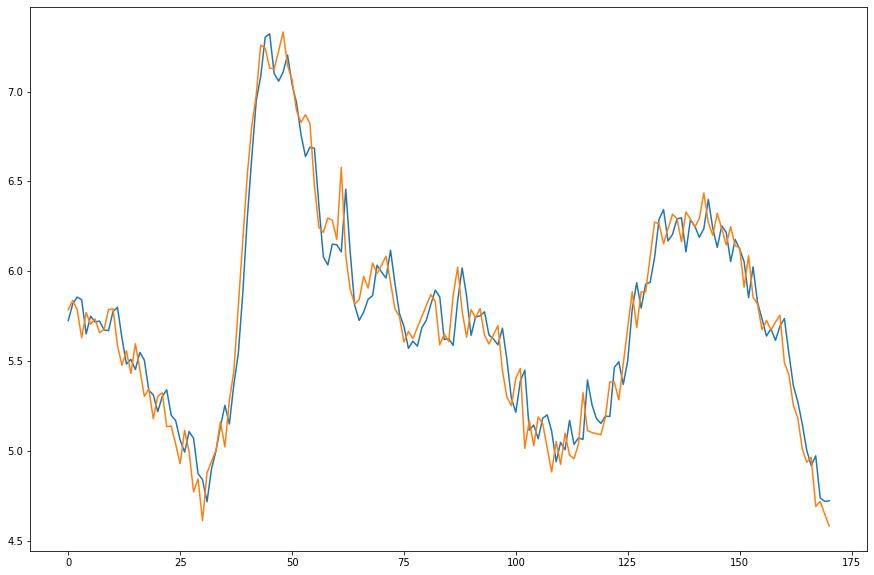

In [381]:
plt.plot(fitting_nn)
plt.plot(y_test)

El modelo ajusta bien, sin embargo, pareciese que está con un lead de un período, caso que no encontrábamos en el bosque aleatorio. Sin embargo, el modelo ajusta bastante bien la varianza de los datos.

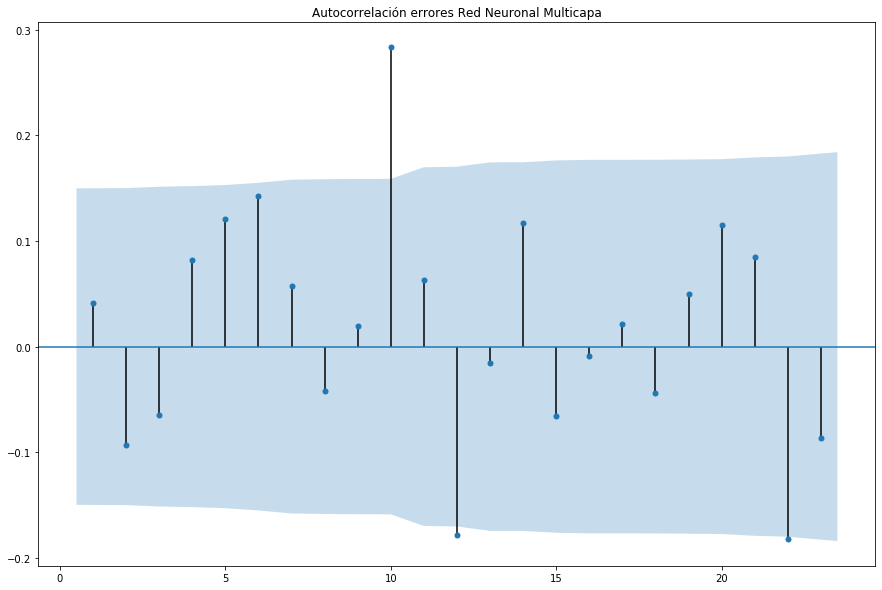

In [382]:
_=plot_acf(y_test.reshape(171,) - fitting_nn, zero = False, title = 'Autocorrelación errores Red Neuronal Multicapa')

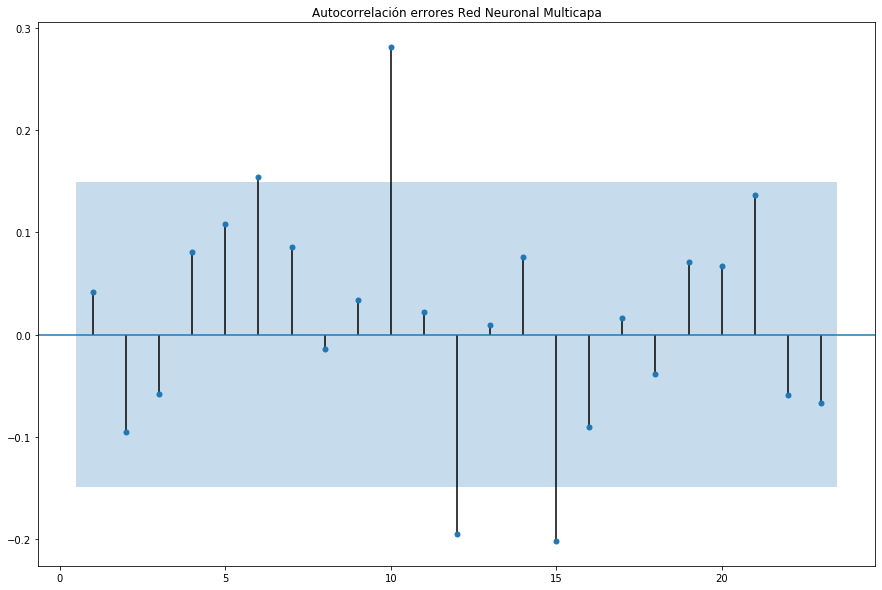

In [383]:
_=plot_pacf(y_test.reshape(171,) - fitting_nn, zero = False, title = 'Autocorrelación errores Red Neuronal Multicapa')

En estas funciones de autocorrelación, tenemos un problema de alta significancia en el rezago 10, 12 y 15, similar al modelo anterior. Esto puede ser consecuencia de que a la hora del ajuste el modelo parece que está con un lead de un período. Así mismo, puede deberse a la falta de una covariable que permita ajustar estos períodos.

In [384]:
model_nn_score = model_nn.score(X_test, y_test)

In [385]:
# R cuadrado del modelo
model_nn_r = np.sum((fitting_nn - np.mean(y_test))**2)/np.sum((y_test - np.mean(y_test))**2)

In [386]:
# Normalidad de los errores
model_nn_norm = jarque_bera(y_test - fitting_nn)[1]

In [387]:
modelos = modelos.append({'Modelo':'Red Neuronal (Serie Original)',
                        'Score': model_nn_score,
                        'R2': model_nn_r,
                        'Normalidad': model_nn_norm}, ignore_index = True)

## Red Neuronal Serie Diferenciada

In [388]:
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=200))
])

parameters = {    
      'model__solver' : ['lbfgs', 'adam', 'sgd'],
      'model__hidden_layer_sizes' : [(10,), (20,), (40,), (80,), (160,), (240,),], 
      'model__activation' : ['identity', 'logistic', 'tanh', 'relu'],
      'model__learning_rate': ['constant', 'adaptive']
}


grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv = 5,
                           verbose = 3)

In [389]:
grid_search.fit(X_train_diff,y_train_diff)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.070, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.165, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=-0.038, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=id

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.007, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.098, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.036, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-1.164, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(10,), m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



[CV]  model__activation=identity, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.579, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.071, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=0.167, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.038, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(20

[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=-0.236, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=-0.363, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=-0.591, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=sgd, score=-0.189, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(40,), model_

[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=sgd, score=-0.064, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.069, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.167, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=identity, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.037, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(80

[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.155, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=-0.041, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.041, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.053, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(1

[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=-0.037, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.036, total=   0.1s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.060, total=   0.0s
[CV] model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=identity, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=sgd, score=-0.128, total=   0.2s
[CV] model__activation=identity, model__hidden_layer_sizes=(24

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.018, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.025, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.013, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.012, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model_

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.061, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.025, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.056, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(10,), model__learning_rate=adapti

[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.083, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.013, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.040, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.072, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(20,), mod

[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=-0.008, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=-0.039, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=-0.080, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=sgd, score=-0.000, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(80,), model_

[CV]  model__activation=logistic, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=sgd, score=0.015, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.074, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.163, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-0.034, total=   0.0s
[CV] model__activation=logistic, model__hidden_layer_size

[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.038, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=0.056, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.072, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=logistic, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.160, total=   0.1s
[CV] model__activation=logistic, model__hidden_layer_sizes=

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\

[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=-0.162, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=-0.084, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.039, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.099, total=   0.1s

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.006, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.115, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.012, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=sgd, score=-0.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\

[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.162, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.084, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.039, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.099, total=   0.1s

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-0.006, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-0.115, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-0.012, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=sgd, score=-0.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.754, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.214, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.452, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.319, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.187, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.080, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.104, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.120, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=constant, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.754, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.214, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.452, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.319, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.187, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.080, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.104, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.120, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.875, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.429, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.294, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.140, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.188, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.084, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.171, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=-0.034, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=constant, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.875, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.429, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.294, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.140, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.188, total=   0.2s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.084, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.171, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=-0.034, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.286, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.514, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.077, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.161, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.066, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.167, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=-0.046, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=constant, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.286, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.514, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.077, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.161, total=   0.3s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.066, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.167, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=-0.046, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-0.352, total=   0.5s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.041, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=0.059, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.077, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.352, total=   0.5s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.041, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.059, total=   0.0s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.077, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(160,), model__learning_rate=

[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.074, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.170, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=-0.037, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.037, total=   0.1s
[CV] model__activation=tanh, model__hidden_layer_sizes=(240,), model__learning_rate=adapt

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=-0.618, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=-0.159, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=lbfgs, score=0.007, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.382, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.010, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=0.009, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, model__solver=adam, score=-0.215, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=constant, mo

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.618, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.159, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=lbfgs, score=0.007, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-0.382, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.010, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=0.009, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, model__solver=adam, score=-0.215, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(10,), model__learning_rate=adaptive, mo

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-1.073, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.429, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.980, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.492, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=lbfgs, score=-0.205, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.242, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=0.011, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, model__solver=adam, score=-0.046, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=constant, 

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.429, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.980, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.492, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.205, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.242, total=   0.1s

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.011, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.046, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=-0.054, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(20,), model__learning_rate=adaptive, model__solver=adam, score=0.

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-4.528, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.380, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.983, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.409, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=lbfgs, score=-0.529, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.001, total=   0.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant, model__solver=adam, score=0.157, total=   0.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=constant,

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-4.528, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.380, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.983, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.409, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.529, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.001, total=   0.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive, model__solver=adam, score=0.157, total=   0.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(40,), model__learning_rate=adaptive,

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-2.612, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.935, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.758, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.896, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=lbfgs, score=-0.711, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.027, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=0.193, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, model__solver=adam, score=-0.039, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=constant, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-2.612, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.935, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.758, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.896, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.711, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.027, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=0.193, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, model__solver=adam, score=-0.039, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(80,), model__learning_rate=adaptive, m

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-4.983, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-1.206, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-1.218, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-0.942, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=lbfgs, score=-0.875, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.079, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=0.170, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=constant, model__solver=adam, score=-0.109, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=con

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=-4.983, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=-1.206, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=-1.218, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.942, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.875, total=   0.7s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.079, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=0.170, total=   0.2s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=adaptive, model__solver=adam, score=-0.109, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(160,), model__learning_rate=ada

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=-3.292, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=-0.970, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=-1.672, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=-1.039, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=lbfgs, score=-0.667, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.020, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=0.205, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=constant, model__solver=adam, score=-0.180, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=con

D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=-3.292, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.970, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=-1.672, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=-1.039, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs 


D:\anacoda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=lbfgs, score=-0.667, total=   1.0s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.020, total=   0.1s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=0.205, total=   0.4s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam 
[CV]  model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=adaptive, model__solver=adam, score=-0.180, total=   0.3s
[CV] model__activation=relu, model__hidden_layer_sizes=(240,), model__learning_rate=ada

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        MLPRegressor(activation='relu',
                                                     alpha=0.0001,
                                                     batch_size='auto',
                                                     beta_1=0.9, beta_2=0.999,
                                                     early_stopping=False,
                                                     epsilon=1e-08,
                                                     hidden_layer_sizes=(100,),
                                                     learning_rate='constant',
                                                     learning_rate_init=0.001,
                                                     max_fun=15000,
                                                     max_iter=200, momentum=0.9,
                                                  

In [390]:
print(f"Mejor Score: {grid_search.best_score_}")
print("Mejor Configuración de parámetros")

best_parameters = grid_search.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")


Mejor Score: 0.06696632264794056
Mejor Configuración de parámetros
	model__activation: logistic
	model__hidden_layer_sizes: (240,)
	model__learning_rate: constant
	model__solver: adam


En este caso, la red neuronal nos sugiere una función de activación de tipo logística, una capa oculta con 240 neuronas y un algoritmo de resolución de tipo adam. Parece que volvemos a tener el problema de un bajo score en la validación cruzada, y esto es constante a través de los tres modelos identificados y ajustados para los datos diferenciados.

In [391]:
model_nn_diff = MLPRegressor(activation = 'logistic', hidden_layer_sizes = (240,), learning_rate = 'constant', 
             solver = 'adam', random_state=200)

In [392]:
fitting_nn_diff = model_nn_diff.fit(X_train_diff, y_train_diff).predict(X_test_diff)

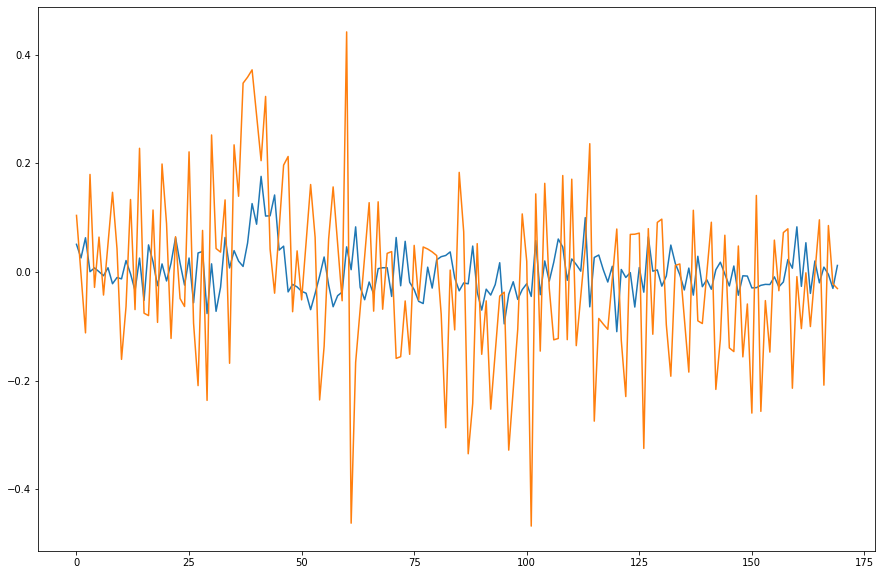

In [393]:
plt.plot(fitting_nn_diff)
plt.plot(y_test_diff)

El modelo parece ajustar bastante mejor la varianza que el modelo anterior realizado para la serie diferenciada, a pesar de que no captura de manera satisfactoria la varianza de los picos que se encuentran a lo largo de la serie, se nota que mejora un poco el ajuste con respecto al modelo anterior.

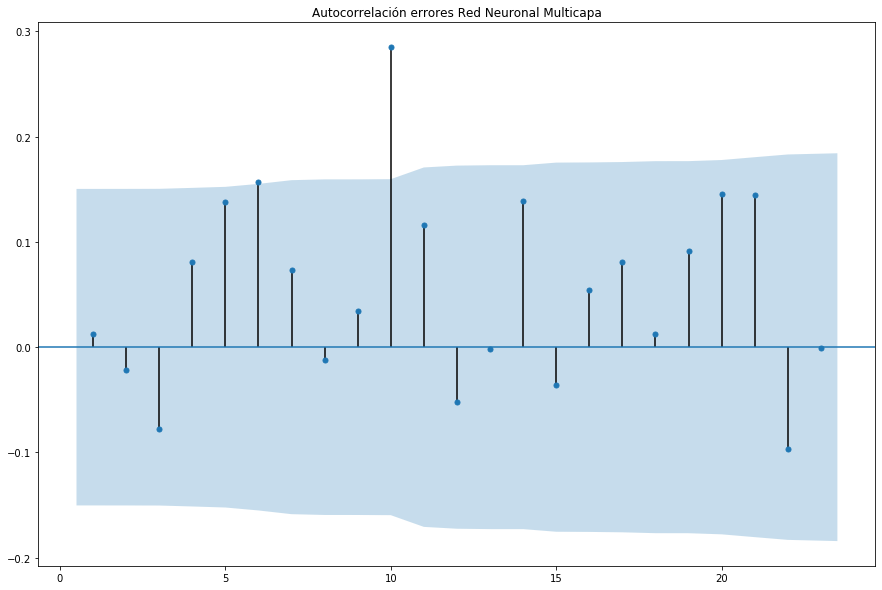

In [394]:
_=plot_acf(y_test_diff.reshape(170,) - fitting_nn_diff, zero = False, title = 'Autocorrelación errores Red Neuronal Multicapa')

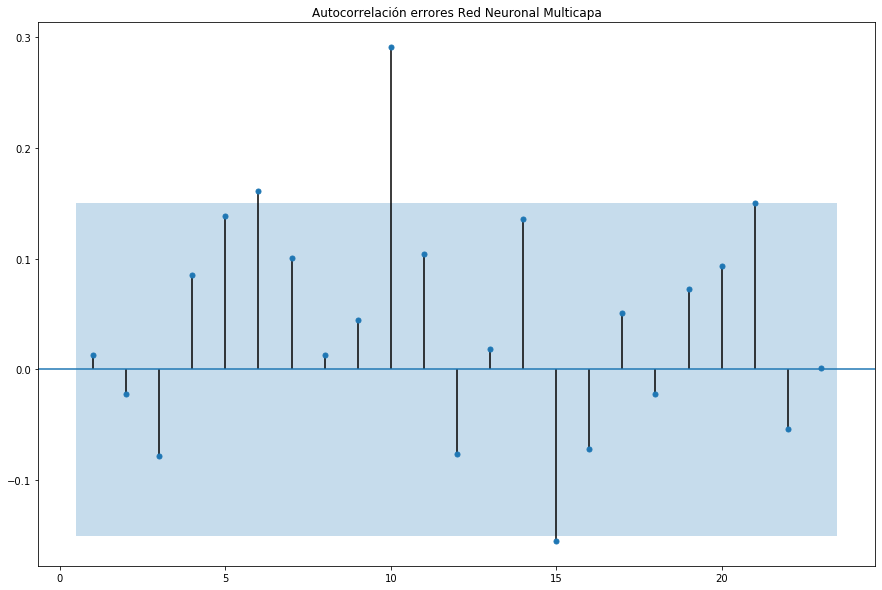

In [395]:
_=plot_pacf(y_test_diff.reshape(170,) - fitting_nn_diff, zero = False, title = 'Autocorrelación errores Red Neuronal Multicapa')

A pesar de que nuevamente hay un rezago significativo en 6 y 15, estos valores son muy bajos y apenas son estadísticamente significativos, el rezago 10 vuelve a presentar valores altos. Esto pasa principalmente en los últimos dos modelos. Puede deberse a la falta de una covariable que permita identificar estos rezagos de manera adecuada.

In [396]:
model_nn_diff_score = model_nn_diff.score(X_test_diff, y_test_diff)

In [397]:
# R cuadrado del modelo
model_nn_diff_r = np.sum((fitting_nn_diff - np.mean(y_test_diff))**2)/np.sum((y_test_diff - np.mean(y_test_diff))**2)

In [398]:
# Normalidad de los errores
model_nn_diff_norm = jarque_bera(y_test_diff - fitting_nn_diff)[1]

In [399]:
modelos = modelos.append({'Modelo':'Red Neuronal (Serie Diferenciada)',
                        'Score': model_nn_diff_score,
                        'R2': model_nn_diff_r,
                        'Normalidad': model_nn_diff_norm}, ignore_index = True)

In [400]:
print(modelos)

                                   Modelo     Score        R2  Normalidad
0      Árbol de Decisión (Serie Original)  0.918591  0.973596    0.853418
1  Árbol de Decisión (Serie Diferenciada) -0.032950  0.017018    0.624991
2       Bosque Aleatorio (Serie Original)  0.939826  0.926275    0.575673
3   Bosque Aleatorio (Serie Diferenciada)  0.074337  0.040579    0.589963
4           Red Neuronal (Serie Original)  0.938081  0.872721    0.922637
5       Red Neuronal (Serie Diferenciada)  0.033340  0.086704    0.800220


Finalmente, a manera de resumen, se tienen los resultados de los tres modelos ajustados para las series. Es positivo resaltar que los errores a lo largo de los modelos son normales (la normalidad muestra el p-valor del estadístico Jarque-Bera, por lo que ninguno rechaza la hipótesis nula de que los errores tienen una distribución normal). A la hora de clasificar los modelos realizados a la serie original, nos encontramos con que el modelo con mejor score es el del bosque aleatorio, pero tanto la red neuronal como el árbol de decisión le siguen muy de cerca; por lo tanto, el modelo que escogeríamos basándonos sólo en este criterio es el árbol de decisión debido a que es el más simple de los tres y sólo sacrifica un par de centésimas de score. Así mismo, a la hora de escoger nuestro modelo por medio del R2, nos encontramos con que el mejor modelo es este debido a que cuenta con varias décimas de ventaja por encima del siguiente modelo que es el Bosque Aleatorio. 

Sin embargo, los modelos realizados para la serie diferenciada tienen un score muy pobre y un R2 bajo; por lo que para el caso de estos modelos, no se recomendaría el uso de ninguno de ellos sí se tiene una serie diferenciada.